In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('paper')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
from statsmodels.tools.eval_measures import rmse

In [4]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [5]:
sns.set_context('talk')
sns.set_style('white')

In [6]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [7]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'

In [8]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [9]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [10]:
os.listdir('fcmfiles')

['FCM_exp1_100Days.csv',
 'FCM_exp1_140Days.csv',
 'FCM_exp1_60Days.csv',
 'FCM_exp3_140Days.csv',
 'FCM_exp4_140Days.csv']

In [11]:
dflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        dflist.append(d)
df = pd.concat(dflist)
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [12]:
df.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100

In [13]:
df.isna().sum()

PRO           45
ALT           45
sample         0
PRO.1         36
ALT.1         73
experiment     0
day            0
dtype: int64

In [14]:
df['day'] = pd.to_numeric(df['day'])

In [15]:
for c in df.columns:
    if c in ['PRO.1', 'ALT.1']:
        continue
    print(c, df[c].unique())

PRO ['MED4' 'MIT9313' 'MIT9312' 'Natl2A' 'MIT0604' nan]
ALT ['1A3' 'DE' 'DE1' 'BS11' 'ATCC' nan]
sample ['1A' '1B' '1C' '2A' '2B' '2C' '3A' '3B' '3C' '4A' '4B' '4C' '5A' '5B'
 '5C' '6A' '6B' '6C' '7A' '7B' '7C' '8A' '8B' '8C' '9A' '9B' '9C' '10A'
 '10B' '10C' '11A' '11B' '11C' '12A' '12B' '12C' '13A' '13B' '13C' '14A'
 '14B' '14C' '15A' '15B' '15C' '16A' '16B' '16C' '17A' '17B' '17C' '18A'
 '18B' '18C' '19A' '19B' '19C' '20A' '20B' '20C' '21A' '21B' '21C' '22A'
 '22B' '22C' '23A' '23B' '23C' '24A' '24B' '24C' '25A' '25B' '25C' '26A'
 '26B' '26C' '27A' '27B' '27C' '28A' '28B' '28C' '29A' '29B' '29C' '30A'
 '30B' '30C' '31A' '31B' '31C' '32A' '32B' '32C' '33A' '33B' '33C' '34A'
 '34B' '34C' '35A' '35B' '35C']
experiment ['exp1' 'exp3' 'exp4']
day [100 140  60]


In [16]:
df.dtypes

PRO            object
ALT            object
sample         object
PRO.1         float64
ALT.1         float64
experiment     object
day             int64
dtype: object

In [17]:
_df = pd.read_pickle('CCPA.pkl.gz')
_df.loc[_df.PRO == 'C9B', 'PRO'] = 'MIT0604'
df1 = _df.loc[(_df.experiment.isin(['e1']))]

In [18]:
day60 = df1.loc[(df1.day >59) & (df1.day < 61), 'day' ].unique()[0]
day100 = df1.loc[(df1.day >100) & (df1.day < 101), 'day' ].unique()[0]
day140 = df1.loc[(df1.day >139) & (df1.day < 141), 'day' ].unique()[0]
df1 = df1.loc[df1.day.isin([day60, day100,day140])]
df1['day'] = df1['day'].map({day60:60, day100:100, day140:140})
df1.experiment = 'exp1'
df1.head()


day experiment sample     FL   PRO  ALT     culture  FL_orig     logFL  \
39    60       exp1     1A  0.558  MED4  1A3  Co_Culture    0.558 -0.583396   
68   100       exp1     1A  0.356  MED4  1A3  Co_Culture    0.356 -1.032825   
87   140       exp1     1A  0.079  MED4  1A3  Co_Culture    0.079 -2.538307   
127   60       exp1     1B  0.680  MED4  1A3  Co_Culture    0.680 -0.385662   
156  100       exp1     1B  0.403  MED4  1A3  Co_Culture    0.403 -0.908819   

     cumsumFL  cumsumlogFL  zscoreFL  diffFL  difflogFL   diffday    rateFL  \
39     95.598    11.366955 -0.376854  -0.029  -0.050666  0.631944 -0.045890   
68    112.389    -4.998736 -0.477633  -0.047  -0.124006  1.059722 -0.044351   
87    115.576   -42.125818 -0.615830  -0.009  -0.107889  1.900000 -0.004737   
127   101.031    15.665516 -0.372846   0.121   0.195943  0.631944  0.191473   
156   120.126     3.203152 -0.513839  -0.045  -0.105857  1.059722 -0.042464   

     ratelogFL experiment_sample  
39   -0.080175            e1, 1A  
68   -0.117017            e1, 1A  
87   -0.056784            e1, 1A  
127   0.310064            e1, 1B  
156  -0.099891            e1, 1B

In [19]:
# add the FL numbers from experiment1 to the table
df = df.merge(df1.loc[:,['day', 'sample', 'FL', 'experiment']], 
        how='left', on=['experiment','sample', 'day'], validate='one_to_one')

In [20]:
df.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day     FL
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  0.356
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  0.403
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  0.626
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  0.101
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  0.050

In [21]:
df_fl = df.dropna(axis=0, subset=['PRO', 'FL'])

In [22]:
# remove the rows where some data is missing. ;leave rows were no data is found but should not be there (e.g. ALT in axenic pro)
df = df.loc[((~df['PRO.1'].isna() & ~df['PRO'].isna()) |
          (~df['ALT.1'].isna() & ~df['ALT'].isna()) )
         ]

In [23]:
df.isna().sum()

PRO            28
ALT            45
sample          0
PRO.1          28
ALT.1          50
experiment      0
day             0
FL            184
dtype: int64

In [24]:
dfall = df.copy()
df.dropna(axis=0, subset=['PRO', 'ALT'], inplace=True)

In [25]:
dfall.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day     FL
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  0.356
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  0.403
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  0.626
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  0.101
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  0.050

In [26]:
dfall['PRO, ALT'] = dfall['PRO'] +', '+ dfall['ALT']
dfall.loc[dfall.PRO.isna(), 'PRO, ALT'] = dfall.loc[dfall.PRO.isna(), 'ALT']
dfall.loc[dfall.ALT.isna(), 'PRO, ALT'] = dfall.loc[dfall.ALT.isna(), 'PRO']

dfall['culture'] = 'Co_Culture'
dfall.loc[dfall.PRO.isna(), 'culture'] = 'ALT only'
dfall.loc[dfall.ALT.isna(), 'culture'] = 'PRO only'
dfall['Total'] = dfall['ALT.1'] + dfall['PRO.1']
dfall.loc[dfall.PRO.isna(), 'Total'] = dfall.loc[dfall.PRO.isna(), 'ALT.1']
dfall.loc[dfall.ALT.isna(), 'Total'] = dfall.loc[dfall.ALT.isna(), 'PRO.1']


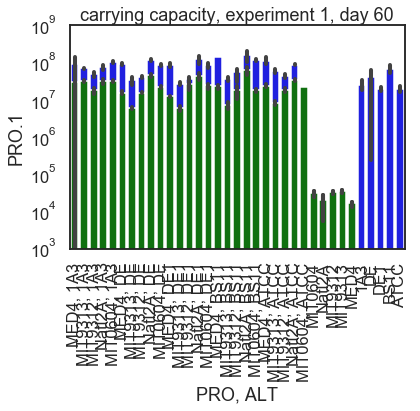

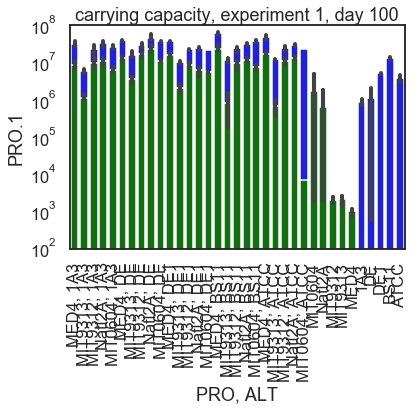

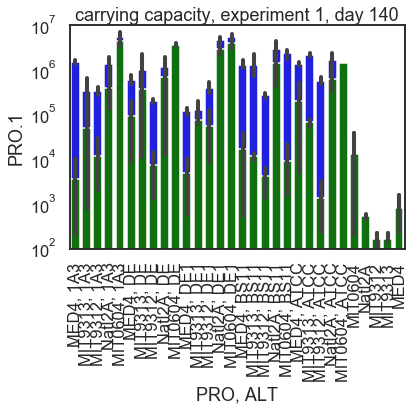

In [27]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x ='PRO, ALT', 
                     #hue='PRO',
                #hue='culture', 
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            x ='PRO, ALT',
                     #hue='PRO',
                #hue='culture', 
                     y='PRO.1', color='green', ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


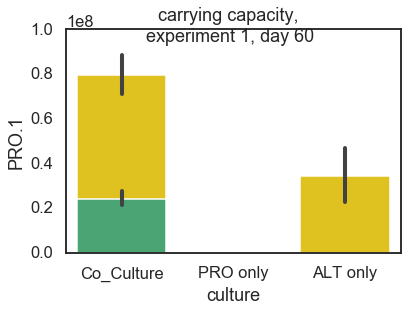

In [28]:
    d = 60 
    #f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [6, 1]}, 
    #                            # figsize=(7,10)
    #                            )
    #for ax in [ax1, ax2]:
    ax=sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='Total', color=ALT_COLOR, #ax=ax
               )

    sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='PRO.1', color=PRO_COLOR, ax=ax)
    #ax.get_legend().remove()
    #plt.yscale('log')
    ax.set_ylim(0,1e8)
    #ax1.set_xlabel("")
    #ax2.set_ylim(0,4e4)
    #sns.despine(ax=ax1, bottom=True)
    #sns.despine(ax=ax2, top=True)
    
    plt.suptitle(f'carrying capacity,\n experiment 1, day {d}')
    plt.show()


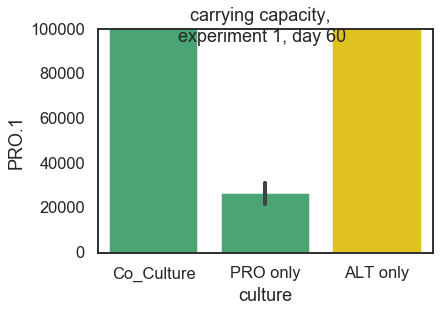

In [29]:
    d = 60 
    #f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [6, 1]}, 
    #                            # figsize=(7,10)
    #                            )
    #for ax in [ax1, ax2]:
    ax=sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='Total', color=ALT_COLOR, #ax=ax
               )

    sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='PRO.1', color=PRO_COLOR, ax=ax)
    #ax.get_legend().remove()
    #plt.yscale('log')
    #ax1.set_ylim(1e7,9e7)
    #ax1.set_xlabel("")
    ax.set_ylim(0,1e5)
    #sns.despine(ax=ax1, bottom=True)
    #sns.despine(ax=ax2, top=True)
    
    plt.suptitle(f'carrying capacity,\n experiment 1, day {d}')
    #plt.yscale('log')
    plt.show()
    

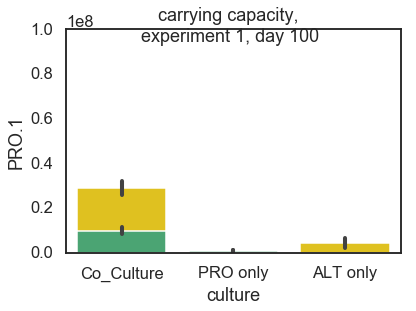

In [30]:
    d = 100 
    #f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 2]})
    #for ax in [ax1, ax2]:
    ax=sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='Total', color=ALT_COLOR, #ax=ax
               )

    sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='PRO.1', color=PRO_COLOR, ax=ax)
    #ax.get_legend().remove()
    #plt.yscale('log')
    #ax1.set_ylim(2.5e7,3.5e7)
    #ax1.set_xlabel("")
    ax.set_ylim(0,1e8)
    #sns.despine(ax=ax1, bottom=True)
    #sns.despine(ax=ax2, top=True)
    
    plt.suptitle(f'carrying capacity,\n experiment 1, day {d}')
    plt.show()


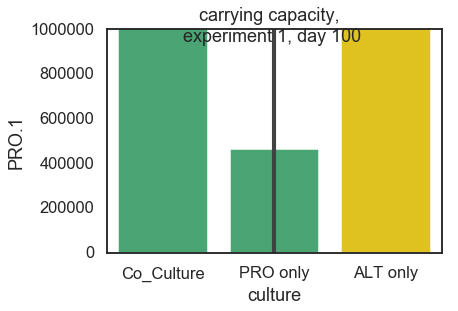

In [31]:
    d = 100 
    #f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [1, 2]})
    #for ax in [ax1, ax2]:
    ax=sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='Total', color=ALT_COLOR, #ax=ax
               )

    sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x='culture', 
                     y='PRO.1', color=PRO_COLOR, ax=ax)
    #ax.get_legend().remove()
    #plt.yscale('log')
    #ax1.set_ylim(2.5e7,3.5e7)
    #ax1.set_xlabel("")
    ax.set_ylim(0,1e6)
    #sns.despine(ax=ax1, bottom=True)
    #sns.despine(ax=ax2, top=True)
    
    plt.suptitle(f'carrying capacity,\n experiment 1, day {d}')
    
    plt.show()


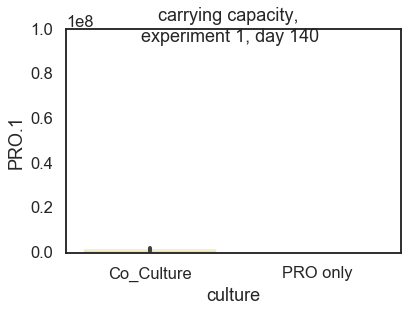

In [32]:
d=140
#f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
#for ax in [ax1, ax2]:
ax =sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
            x='culture', 
                 y='Total', color=ALT_COLOR, #ax=ax
               )

sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
            x='culture', 
                 y='PRO.1', color=PRO_COLOR, ax=ax)
#ax.get_legend().remove()
#plt.yscale('log')
ax.set_ylim(0,1e8)
#ax1.set_xlabel("")
#ax2.set_ylim(0,1e4)
#sns.despine(ax=ax1, bottom=True)
#sns.despine(ax=ax2, top=True)

plt.suptitle(f'carrying capacity,\n experiment 1, day {d}')
plt.show()


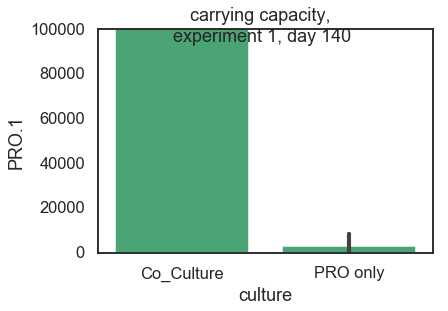

In [33]:
d=140
#f, (ax1, ax2) = plt.subplots(ncols=1, nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1]})
#for ax in [ax1, ax2]:
ax =sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
            x='culture', 
                 y='Total', color=ALT_COLOR, #ax=ax
               )

sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
            x='culture', 
                 y='PRO.1', color=PRO_COLOR, ax=ax)
#ax.get_legend().remove()
#plt.yscale('log')
#ax1.set_ylim(4e5,2.5e6)
#ax1.set_xlabel("")
ax.set_ylim(0,1e5)
#sns.despine(ax=ax1, bottom=True)
#sns.despine(ax=ax2, top=True)

plt.suptitle(f'carrying capacity,\n experiment 1, day {d}')
plt.show()


In [34]:
sns.set_context('talk')

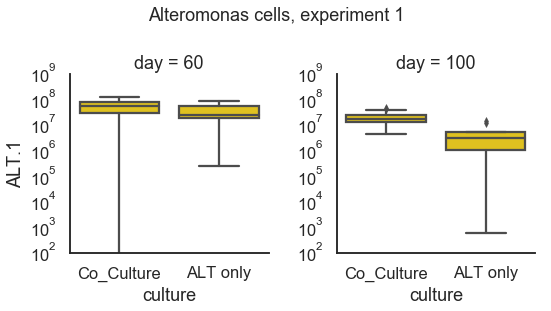

day=60 Ttest_indResult(statistic=2.7387394490570838, pvalue=0.007529210600903086)
day=100 Ttest_indResult(statistic=6.2055728134674775, pvalue=1.9772383801176403e-08)


In [35]:
sns.catplot(data=dfall.loc[(dfall.experiment == 'exp1')&
                           (dfall.culture != 'PRO only') &
                           (dfall.day != 140)
                          ].fillna(0),
                x='culture', 
                     y='ALT.1', col='day',
            kind='box',
            sharey=False,
            color=ALT_COLOR,
            facet_kws=dict(subplot_kws=dict(yscale='log', ylim=(1e2,1e9))),
            height=4,
                   )


plt.suptitle(f'Alteromonas cells, experiment 1', y=1.1)
plt.show()
for day in [60,100]:
    print(f'day={day}', stats.ttest_ind(
        dfall.loc[(dfall.experiment == 'exp1')&(dfall.day == day)&
                  (dfall.culture == 'Co_Culture'), 'ALT.1'
                 ].dropna(), 
        dfall.loc[(dfall.experiment == 'exp1')&(dfall.day == day)&
                  (dfall.culture == 'ALT only'), 'ALT.1'
                 ].dropna()))
    

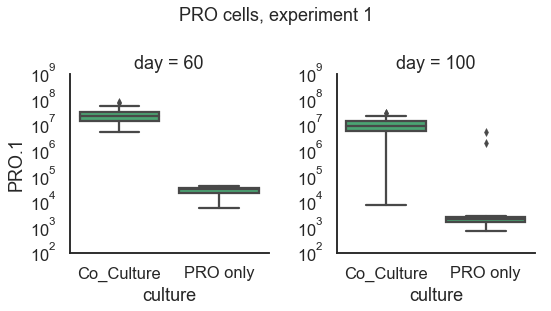

day=60 Ttest_indResult(statistic=6.513651102735099, pvalue=4.737550066995795e-09)
day=100 Ttest_indResult(statistic=5.429712102261257, pvalue=5.150855380193557e-07)


In [36]:
sns.catplot(data=dfall.loc[(dfall.experiment == 'exp1')&
                           (dfall.culture != 'ALT only') &
                           (dfall.day != 140)
                          ].fillna(0),
                x='culture', 
                     y='PRO.1', color=PRO_COLOR, col='day',
            kind='box',
            sharey=False,
            height=4,
            facet_kws=dict(subplot_kws=dict(yscale='log', ylim=(1e2,1e9))),            
                   )


plt.suptitle(f'PRO cells, experiment 1', y=1.1)
plt.show()
for day in [60,100]:
    print(f'day={day}', stats.ttest_ind(
        dfall.loc[(dfall.experiment == 'exp1')&(dfall.day == day)&
                  (dfall.culture == 'Co_Culture'), 'PRO.1'
                 ].dropna(), 
        dfall.loc[(dfall.experiment == 'exp1')&(dfall.day == day)&
                  (dfall.culture == 'PRO only'), 'PRO.1'
                 ].dropna()))
    

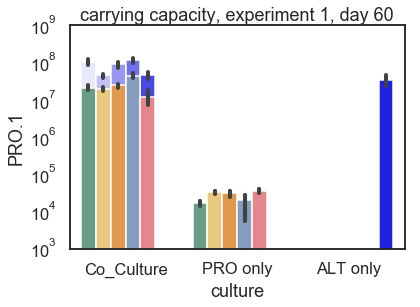

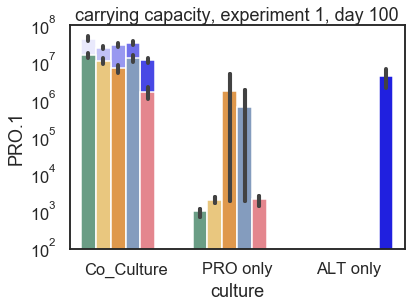

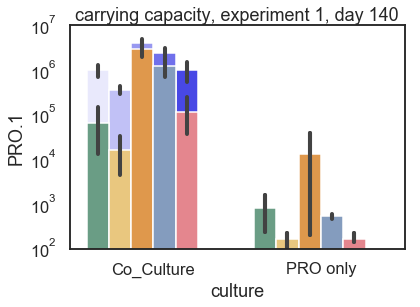

In [37]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                #units ='PRO, ALT', 
                     hue='PRO',
                     hue_order=porder+ [0],
                x='culture', 
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            #units ='PRO, ALT',
                     hue='PRO',
                    hue_order=porder+ [0],
                     palette=ppallete + ['red'],

                x='culture', 
                     y='PRO.1', #color='green', 
                     ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    ax.get_legend().remove()
    #ax.xticks(rotation=90)
    #plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


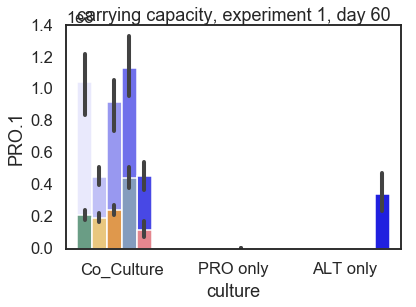

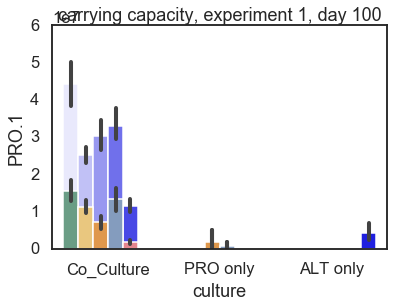

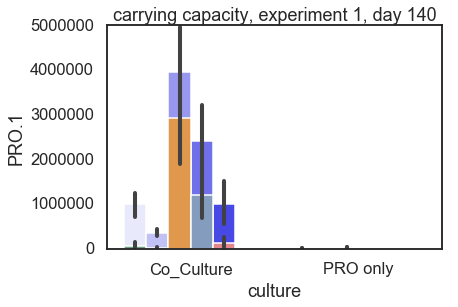

In [38]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                #units ='PRO, ALT', 
                     hue='PRO',
                     hue_order=porder+ [0],
                x='culture', 
                     y='Total', color='blue'
                    )

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            #units ='PRO, ALT',
                     hue='PRO',
                    hue_order=porder+ [0],
                     palette=ppallete + ['red'],

                x='culture', 
                     y='PRO.1', #color='green', 
                     ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    ax.get_legend().remove()
    #ax.xticks(rotation=90)
    #plt.xticks(rotation='vertical')
    #plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


In [39]:
order_list = [f'{p}, {a}' if a is not None else p for p  in porder for a in (aorder + [None])]
order_list = order_list + aorder


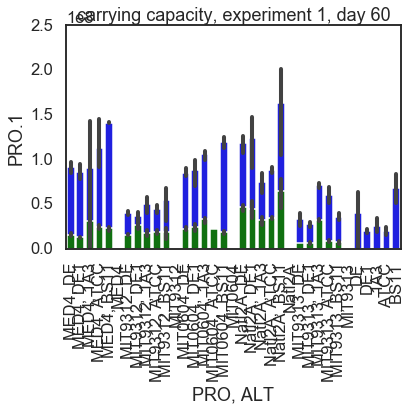

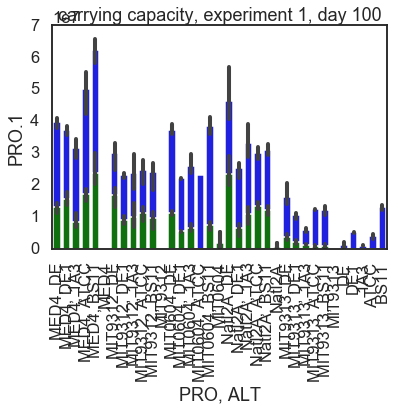

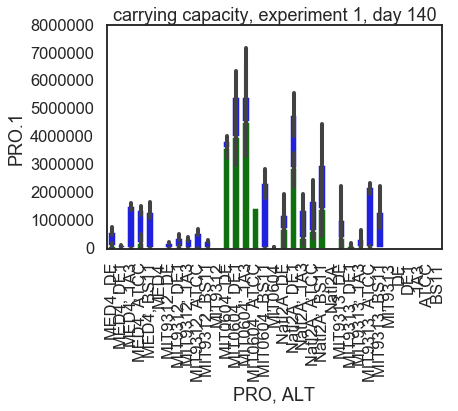

In [40]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x ='PRO, ALT', 
                     #hue='PRO',
                #hue='culture', 
                     order=order_list,
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            x ='PRO, ALT',
                     #hue='PRO',
                     order=order_list,
                #hue='culture', 
                     y='PRO.1', color='green', ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    plt.xticks(rotation='vertical')
    #plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


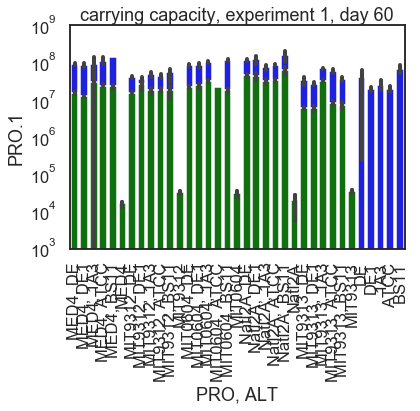

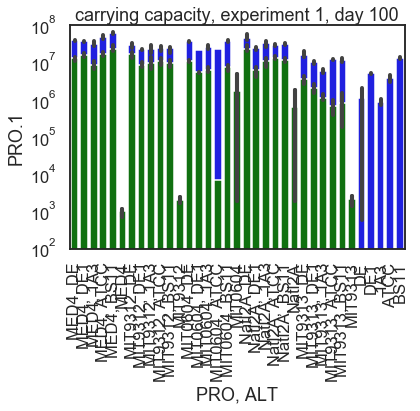

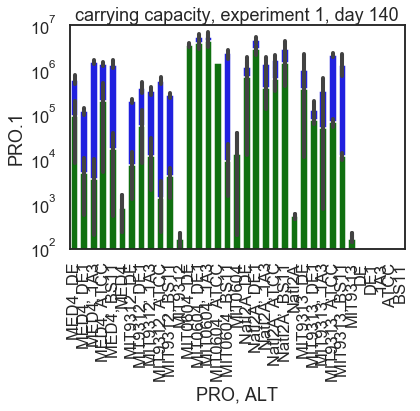

In [41]:
for d in [60,100,140]:
    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                x ='PRO, ALT', 
                     #hue='PRO',
                #hue='culture', 
                     order=order_list,
                     y='Total', color='blue')

    ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
                            x ='PRO, ALT',
                     #hue='PRO',
                     order=order_list,
                #hue='culture', 
                     y='PRO.1', color='green', ax=ax)
    #ax = sns.barplot(data=dfall.loc[(dfall.experiment == 'exp1') & (dfall.day == d)].fillna(0),
    #                        x ='PRO, ALT', 
    #            #hue='culture', 
    #                 y='ALT.1', color='red', ax=ax)
    #plt.legend(None)
    #ax.get_legend().remove()
    #ax.xticks(rotation=90)
    plt.xticks(rotation='vertical')
    plt.yscale('log')
    plt.title(f'carrying capacity, experiment 1, day {d}')
    plt.show()


In [42]:
df.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day', 'FL'], dtype='object')

In [43]:
dfm = df.melt(id_vars=['PRO', 'ALT', 'sample',  'experiment', 'day'], 
              value_name='Cells/ml', value_vars=['PRO.1', 'ALT.1',],
              var_name='Group'
             )
dfm['Group'] = dfm['Group'].map({'PRO.1': 'PRO', 'ALT.1': 'ALT'})

Text(0.5,1,'Cell Counts')

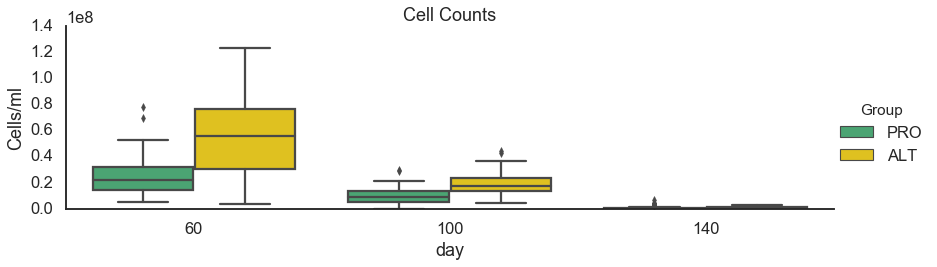

In [44]:
g=sns.catplot(data=dfm.loc[dfm.experiment == 'exp1'],
                 x='day', y='Cells/ml', hue='Group',
                  kind='box',
               aspect=3,
              height=4,
              hue_order=['PRO', 'ALT'], palette=['MediumSeaGreen','Gold'],
              )
#plt.ylim(0,1.4e8)
plt.title("Cell Counts")


Text(0.5,1.05,'Cell Counts')

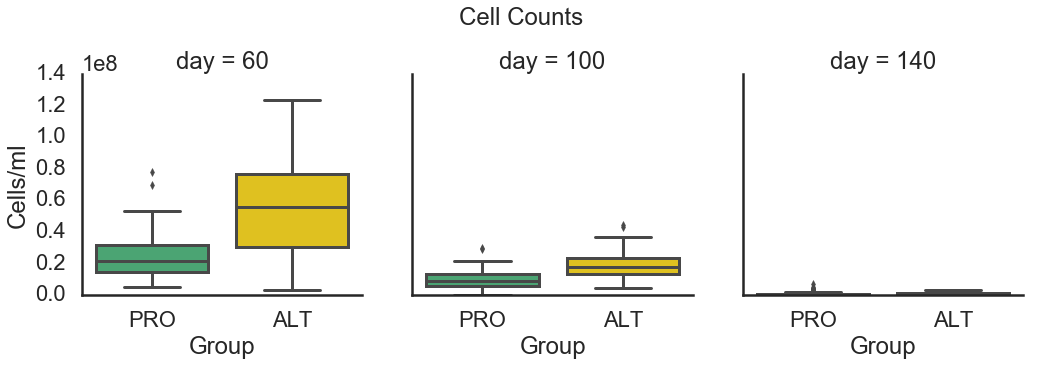

In [45]:

sns.set_context('poster')
g=sns.catplot(data=dfm.loc[(dfm.experiment == 'exp1') & ],
                 col='day', y='Cells/ml', x='Group',
              
                  kind='box',
               aspect=1,
              height=5,
              hue_order=['PRO', 'ALT'], palette=['MediumSeaGreen','Gold'],
              )
#plt.ylim(0,1.4e8)
plt.suptitle("Cell Counts", y=1.05)


In [47]:
dfm.columns

Index(['PRO', 'ALT', 'sample', 'experiment', 'day', 'Group', 'Cells/ml'], dtype='object')

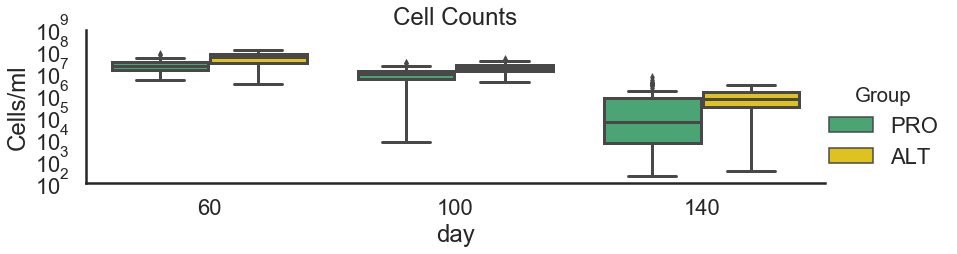

In [46]:
g=sns.catplot(data=dfm.loc[dfm.experiment == 'exp1'],
                 x='day', y='Cells/ml', hue='Group',
                  kind='box',
               aspect=3,
              height=4,
              hue_order=['PRO', 'ALT'], palette=['MediumSeaGreen','Gold'],
              )
#plt.ylim(0,1.4e8)
plt.title("Cell Counts")
plt.yscale('log')


Text(0.5,1,'ALT cell density')

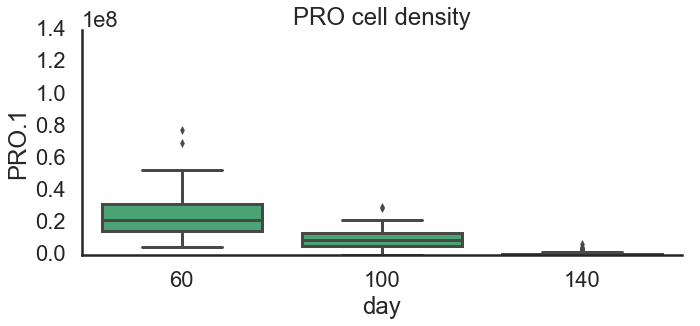

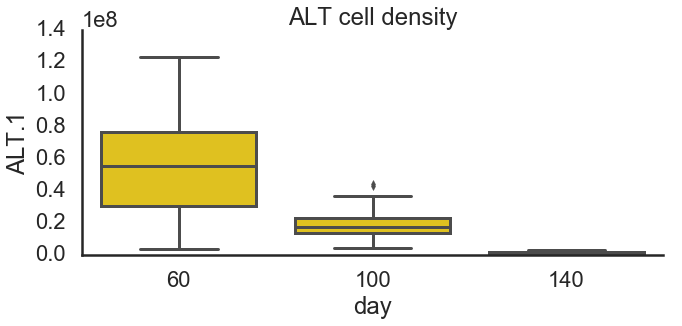

In [47]:
 g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
                 x='day', y='PRO.1', 
                  kind='box',
               aspect=2,
               color='MediumSeaGreen',
              )
 plt.ylim(0,1.4e8)
 plt.title("PRO cell density")
 g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
                 x='day', y='ALT.1', 
                  kind='box',
               aspect=2,
               color='Gold',
              )
 plt.ylim(0,1.4e8)
 plt.title("ALT cell density")


Text(0.5,1.05,'PRO cell counts, per ALT strain,  experiment 1 ')

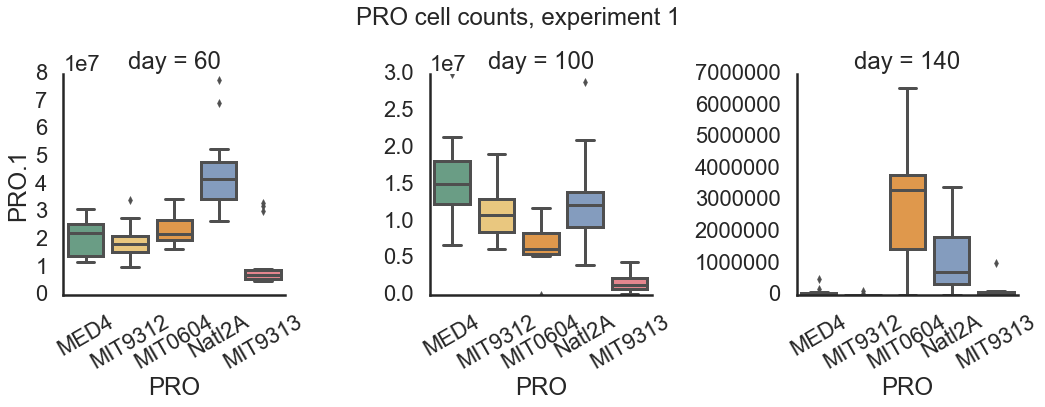

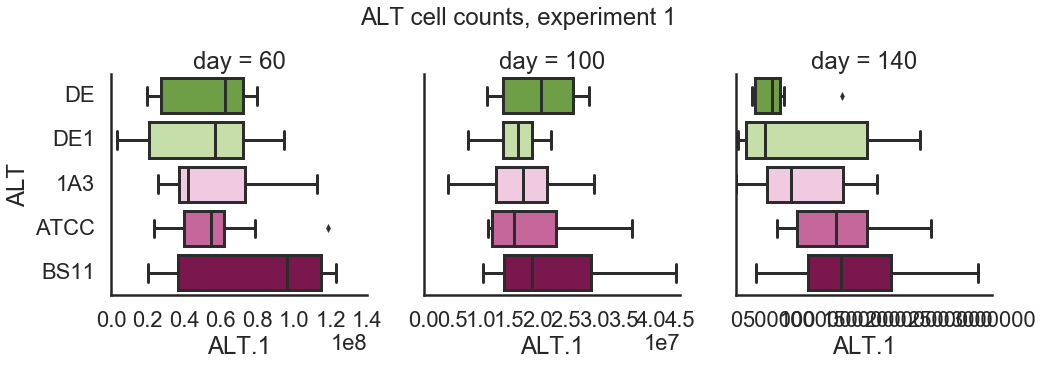

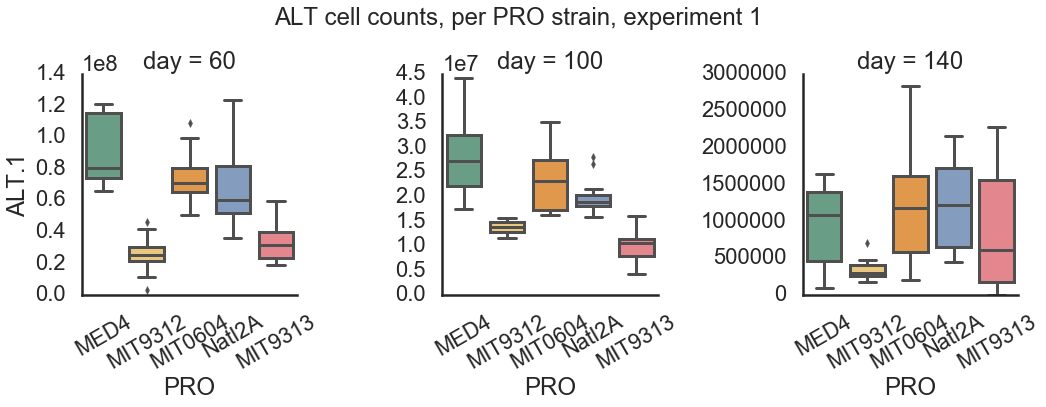

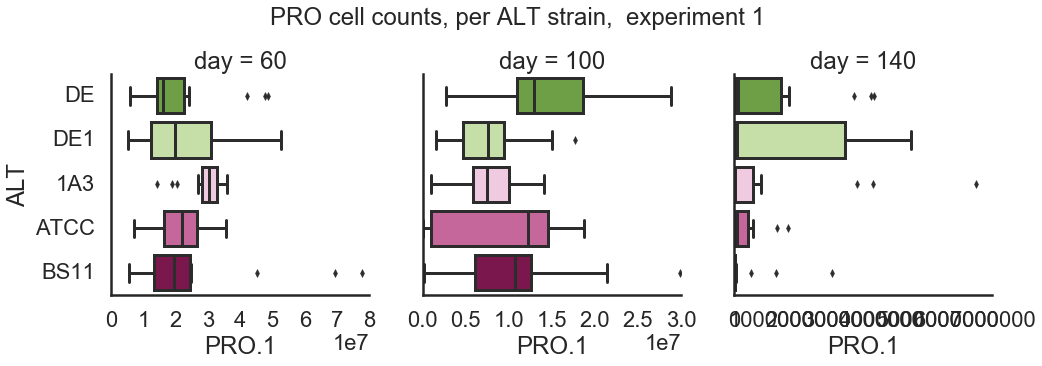

In [48]:
    g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
                 col='day', x='PRO', y='PRO.1', 
                  kind='box',
                  order=porder,
                  sharey=False,
                  palette=ppallete)
    g.set_xticklabels(rotation=30)
    #plt.ylim((0,))
    plt.suptitle('PRO cell counts, experiment 1 ', y=1.05)
    g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
                 col='day', y='ALT', x='ALT.1', 
                  kind='box',
                  order=aorder,
                  sharex=False,
                  palette=apallete)
    #g.set_xticklabels(rotation=30)
    #plt.ylim((0,))
    plt.suptitle('ALT cell counts, experiment 1 ', y=1.05)    
    g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
                 col='day', x='PRO', y='ALT.1', #hue='PRO', 
                  kind='box',
                  order=porder,
                  sharey=False,
                  palette=ppallete)
    g.set_xticklabels(rotation=30)
    #plt.ylim((0,))
    plt.suptitle('ALT cell counts, per PRO strain, experiment 1 ', y=1.05)
    g=sns.catplot(data=df.loc[df.experiment == 'exp1'],
                 col='day', y='ALT', x='PRO.1', 
                  kind='box',
                  order=aorder,
                  sharex=False,
                  palette=apallete)
    #g.set_xticklabels(rotation=30)
    plt.suptitle('PRO cell counts, per ALT strain,  experiment 1 ', y=1.05)


In [49]:
dfall.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day', 'FL',
       'PRO, ALT', 'culture', 'Total'],
      dtype='object')

In [50]:
from statsmodels.formula.api import ols
for d in[60,100,140]:
    dfall1 = dfall.rename(columns={'ALT.1': 'ALTc', 'PRO.1': 'PROc'})
    dfall1 = dfall1.loc[(dfall1.experiment == 'exp1') & (dfall1.day == d)]
    mod = ols('ALTc ~ C(PRO)',
                    data=dfall1).fit()
    print (f'++++++++++++++++++ day = {d} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'ALT cells as function of PRO strain, day={d}')
    pair_t = mod.t_test_pairwise("C(PRO)", method='b')
    print(pair_t.result_frame)
    print(f'ALT cells as function of PRO strain, day={d}')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ day = 60 +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                   ALTc   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     33.98
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           2.19e-15
Time:                        10:00:06   Log-Likelihood:                -1285.6
No. Observations:                  71   AIC:                             2581.
Df Residuals:                      66   BIC:                             2592.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [51]:
from statsmodels.formula.api import ols
for d in[60,100,140]:
    dfall1 = dfall.rename(columns={'ALT.1': 'ALTc', 'PRO.1': 'PROc'})
    dfall1 = dfall1.loc[(dfall1.experiment == 'exp1') & (dfall1.day == d)]
    mod = ols('PROc ~ C(PRO)',
                    data=dfall1).fit()
    print (f'++++++++++++++++++ day = {d} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'PRO cells as function of PRO strain, day={d}')
    pair_t = mod.t_test_pairwise("C(PRO)", method='b')
    print(pair_t.result_frame)
    print(f'PRO cells as function of PRO strain, day={d}')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ day = 60 +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                   PROc   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     10.39
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           7.16e-07
Time:                        10:00:06   Log-Likelihood:                -1565.5
No. Observations:                  88   AIC:                             3141.
Df Residuals:                      83   BIC:                             3153.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [52]:
from statsmodels.formula.api import ols
for d in[60,100,140]:
    dfall1 = dfall.rename(columns={'ALT.1': 'ALTc', 'PRO.1': 'PROc'})
    dfall1 = dfall1.loc[(dfall1.experiment == 'exp1') & (dfall1.day == d)]
    mod = ols('PROc ~ C(ALT)',
                    data=dfall1).fit()
    print (f'++++++++++++++++++ day = {d} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'PRO cells as function of ALT strain, day={d}')
    pair_t = mod.t_test_pairwise("C(ALT)", method='b')
    print(pair_t.result_frame)
    print(f'PRO cells as function of ALT strain, day={d}')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ day = 60 +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                   PROc   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.8258
Date:                Wed, 25 Mar 2020   Prob (F-statistic):              0.513
Time:                        10:00:06   Log-Likelihood:                -1303.9
No. Observations:                  73   AIC:                             2618.
Df Residuals:                      68   BIC:                             2629.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [53]:
from statsmodels.formula.api import ols
for d in[60,100,140]:
    dfall1 = dfall.rename(columns={'ALT.1': 'ALTc', 'PRO.1': 'PROc'})
    dfall1 = dfall1.loc[(dfall1.experiment == 'exp1') & (dfall1.day == d)]
    mod = ols('ALTc ~ C(ALT)',
                    data=dfall1).fit()
    print (f'++++++++++++++++++ day = {d} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'ALT cells as function of ALT strain, day={d}')
    pair_t = mod.t_test_pairwise("C(ALT)", method='b')
    print(pair_t.result_frame)
    print(f'ALT cells as function of ALT strain, day={d}')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ day = 60 +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                   ALTc   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     3.025
Date:                Wed, 25 Mar 2020   Prob (F-statistic):             0.0223
Time:                        10:00:07   Log-Likelihood:                -1599.6
No. Observations:                  86   AIC:                             3209.
Df Residuals:                      81   BIC:                             3221.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [54]:
from statsmodels.formula.api import ols
for d in[60,100,140]:
    dfall1 = dfall.rename(columns={'ALT.1': 'ALTc', 'PRO.1': 'PROc'})
    dfall1 = dfall1.loc[(dfall1.experiment == 'exp1') & (dfall1.day == d)]
    mod = ols('PROc ~ C(ALT)',
                    data=dfall1).fit()
    print (f'++++++++++++++++++ day = {d} +++++++++++++++++++++++')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    print(f'PRO cells as function of ALT strain, day={d}')
    pair_t = mod.t_test_pairwise("C(ALT)", method='b')
    print(pair_t.result_frame)
    print(f'PRO cells as function of ALT strain, day={d}')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

++++++++++++++++++ day = 60 +++++++++++++++++++++++
                            OLS Regression Results                            
Dep. Variable:                   PROc   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.8258
Date:                Wed, 25 Mar 2020   Prob (F-statistic):              0.513
Time:                        10:00:07   Log-Likelihood:                -1303.9
No. Observations:                  73   AIC:                             2618.
Df Residuals:                      68   BIC:                             2629.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

In [55]:
pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b']

Series([], Name: pvalue-b, dtype: float64)

In [56]:
pair_t = mod.t_test_pairwise("C(ALT)", method='b')
pair_t.result_frame

coef        std err         t     P>|t|  Conf. Int. Low  \
ATCC-1A3  -6.807115e+05  540939.344731 -1.258388  0.212555   -1.760139e+06   
BS11-1A3  -7.094224e+05  521262.195528 -1.360970  0.178017   -1.749585e+06   
DE-1A3    -4.867867e+04  521262.195528 -0.093386  0.925871   -1.088841e+06   
DE1-1A3    4.053358e+05  521262.195528  0.777604  0.439499   -6.348267e+05   
BS11-ATCC -2.871090e+04  540939.344731 -0.053076  0.957827   -1.108139e+06   
DE-ATCC    6.320329e+05  540939.344731  1.168399  0.246726   -4.473948e+05   
DE1-ATCC   1.086047e+06  540939.344731  2.007706  0.048650    6.619665e+03   
DE-BS11    6.607438e+05  521262.195528  1.267584  0.209270   -3.794188e+05   
DE1-BS11   1.114758e+06  521262.195528  2.138575  0.036065    7.459570e+04   
DE1-DE     4.540145e+05  521262.195528  0.870991  0.386824   -5.861481e+05   

           Conf. Int. Upp.  pvalue-b  reject-b  
ATCC-1A3      3.987161e+05  1.000000     False  
BS11-1A3      3.307401e+05  1.000000     False  
DE-1A3        9.914838e+05  1.000000     False  
DE1-1A3       1.445498e+06  1.000000     False  
BS11-ATCC     1.050717e+06  1.000000     False  
DE-ATCC       1.711461e+06  1.000000     False  
DE1-ATCC      2.165475e+06  0.486501     False  
DE-BS11       1.700906e+06  1.000000     False  
DE1-BS11      2.154921e+06  0.360652     False  
DE1-DE        1.494177e+06  1.000000     False

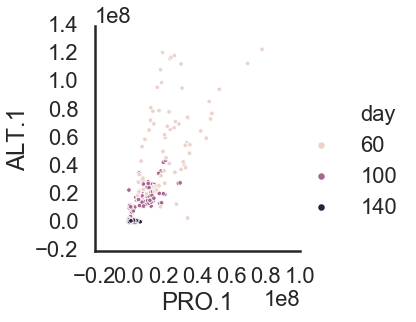

In [57]:
g= sns.relplot(data=df.loc[df.experiment=='exp1'], 
               x='PRO.1', y='ALT.1', hue='day', legend='full'
            #hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
           )


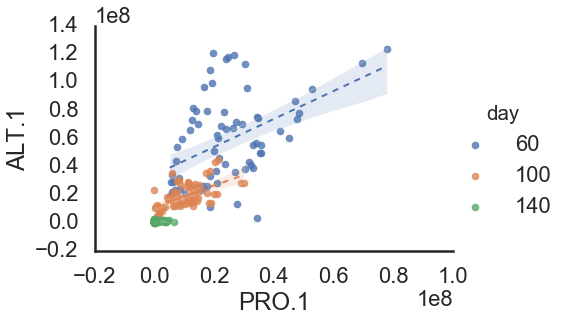

In [58]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', hue='day', legend='full',
           #hue_order=oorder, palette=opalette,
           aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=50),
           line_kws=dict(linewidth=2, linestyle='dashed'),
           truncate=True
          )
#plt.title('Number of alternative ORFs vs genome size')
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

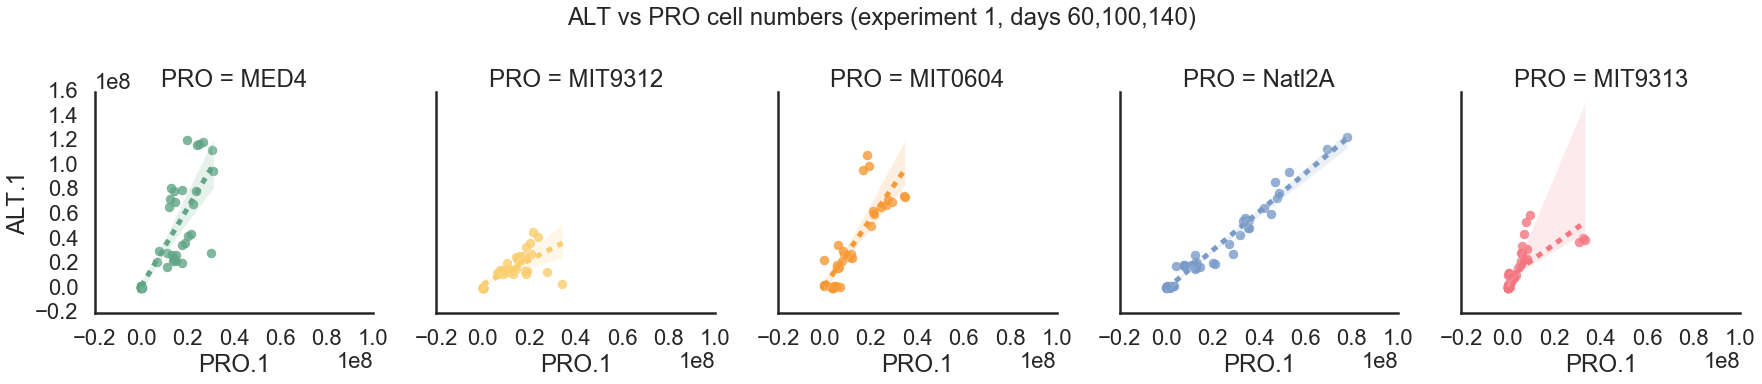

In [59]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

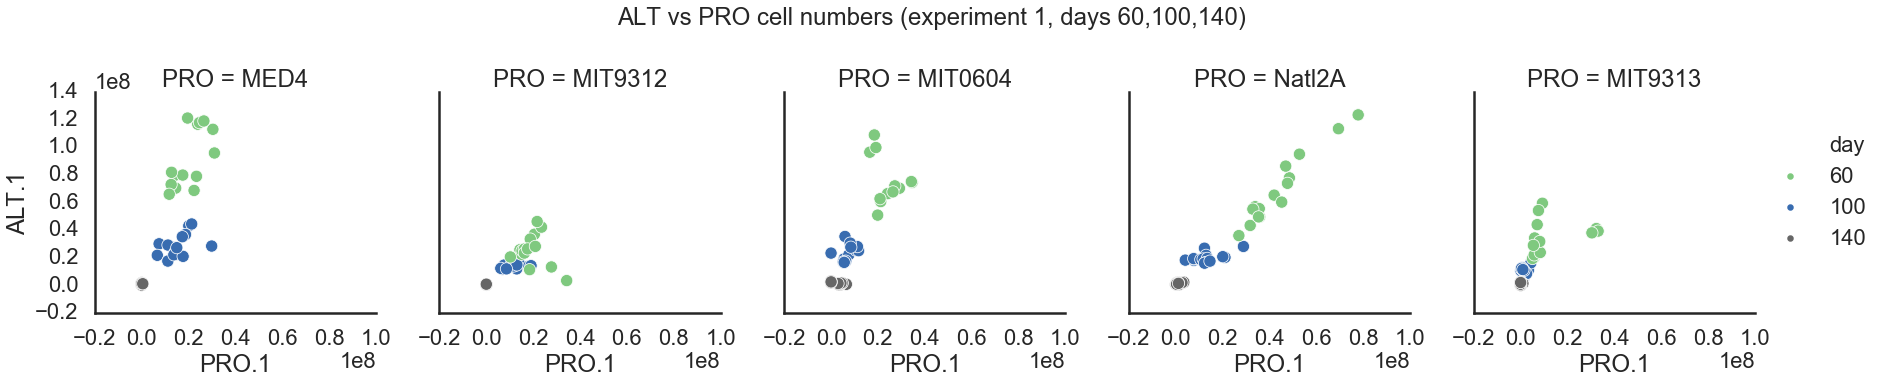

In [60]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
            s=150,
            palette='Accent'
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

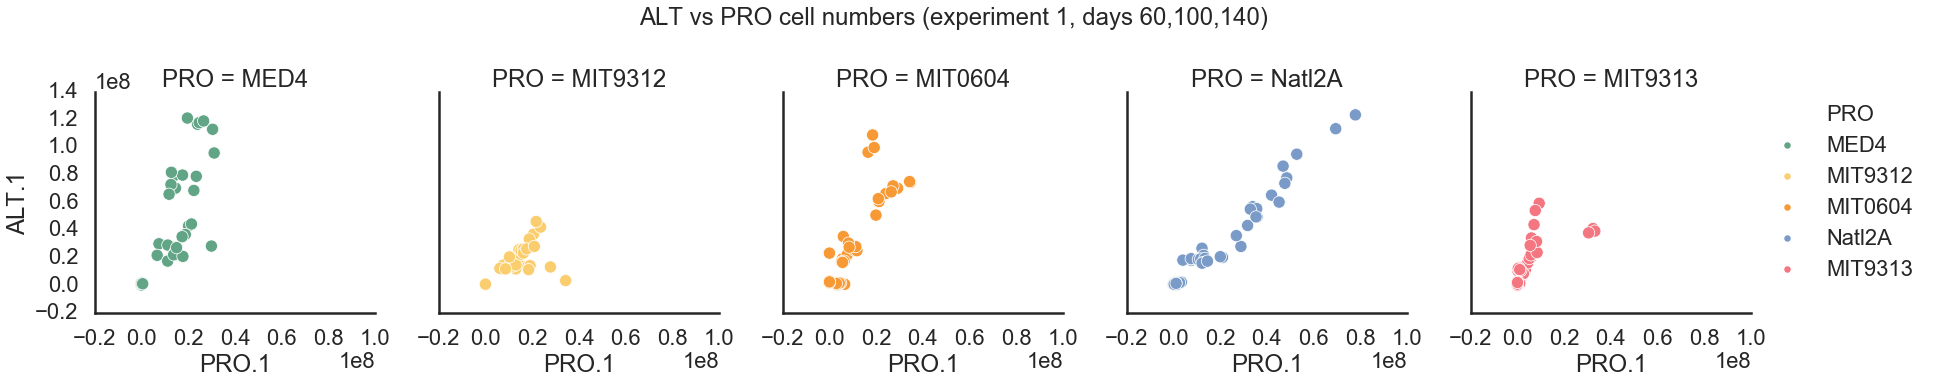

In [61]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
            s=150,
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

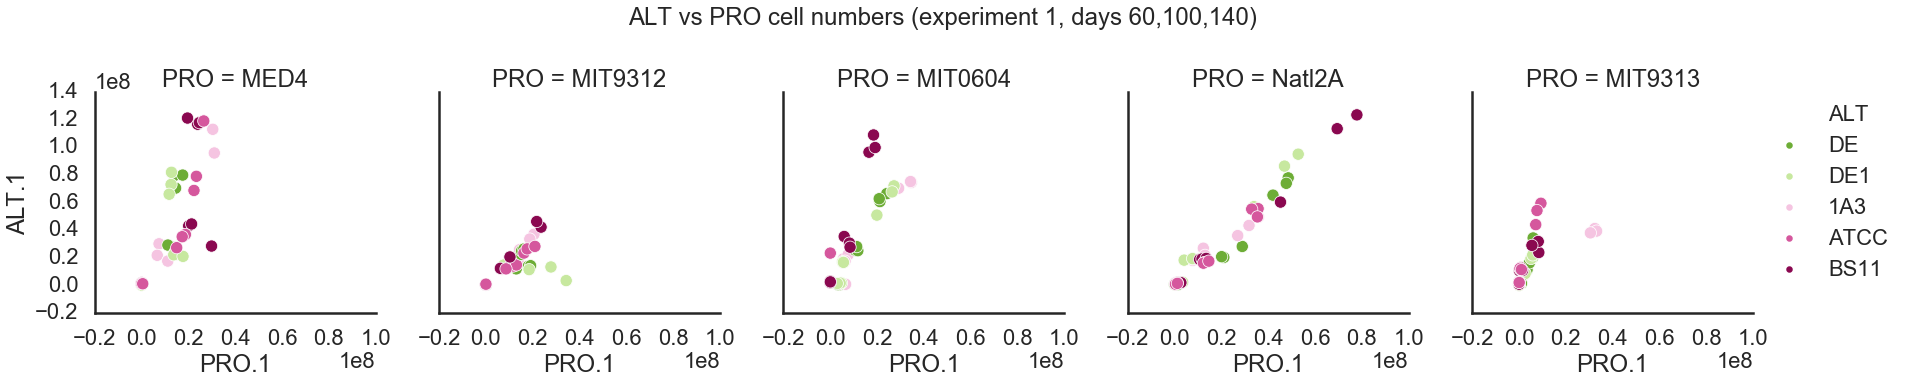

In [62]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='PRO', hue='ALT', legend='full',
           col_order=porder, hue_order=aorder, palette=apallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
            s=150
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'ALT vs PRO cell numbers (experiment 1, days 60,100,140)')

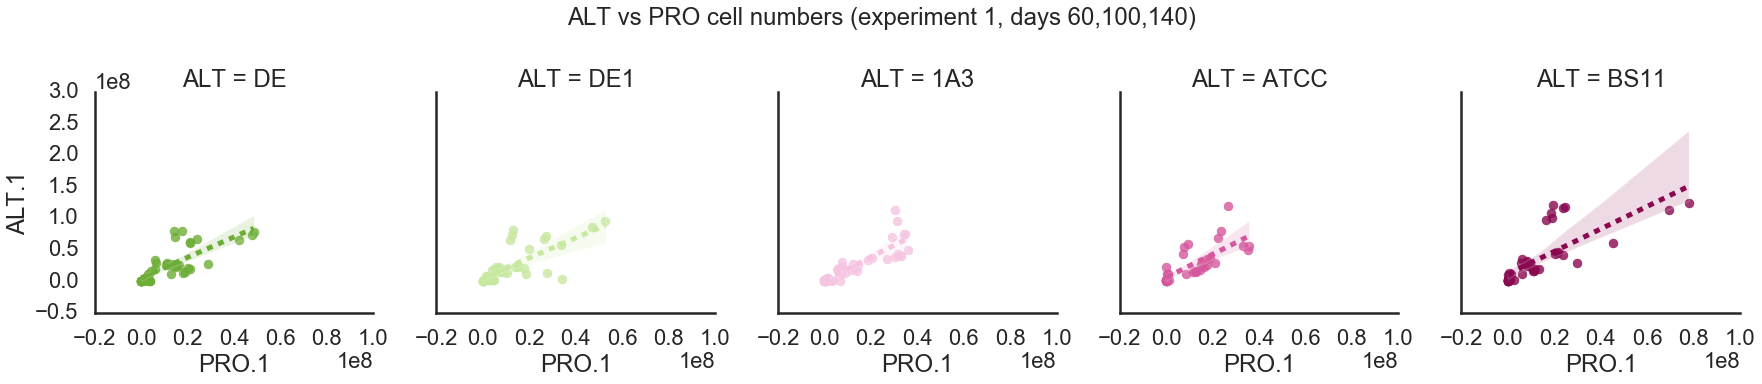

In [63]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', col='ALT', hue='ALT', legend='full',
           col_order=aorder, hue_order=aorder, palette=apallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True
          )
plt.suptitle('ALT vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

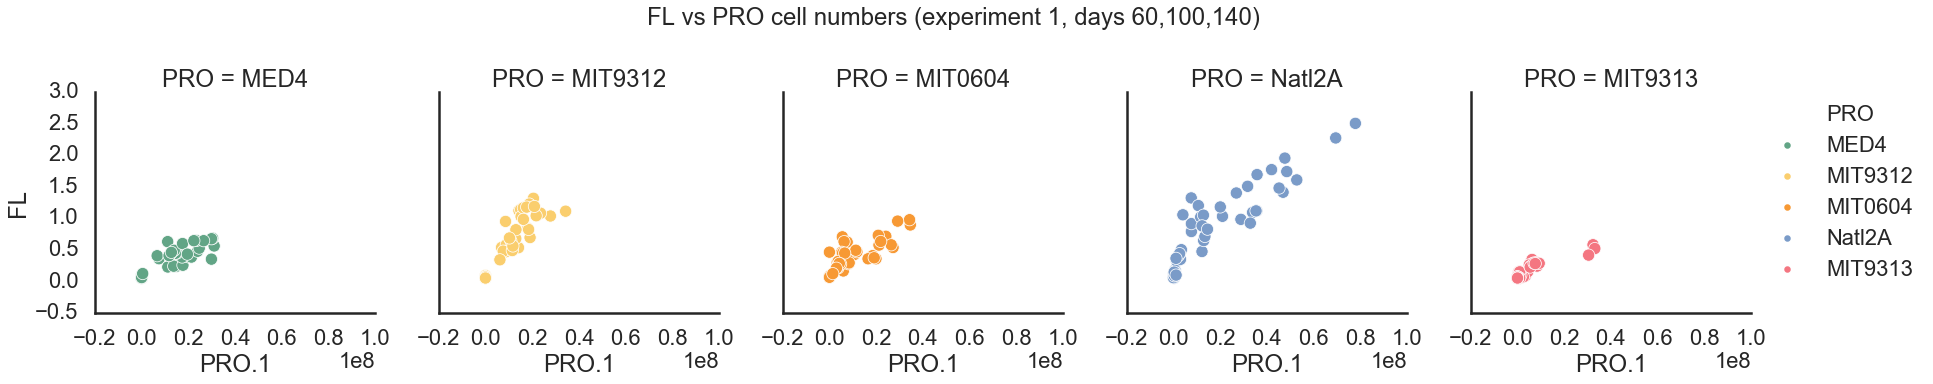

In [64]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

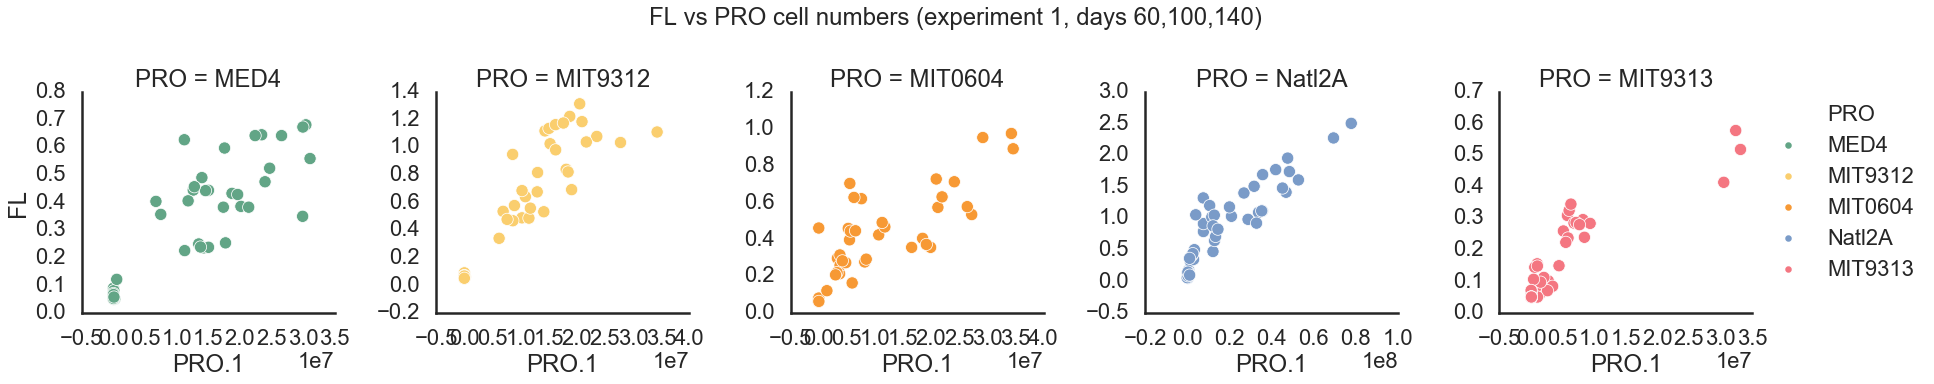

In [65]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='PRO', legend='full',
           col_order=porder, hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
                        facet_kws=dict(sharex=False, sharey=False),

          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

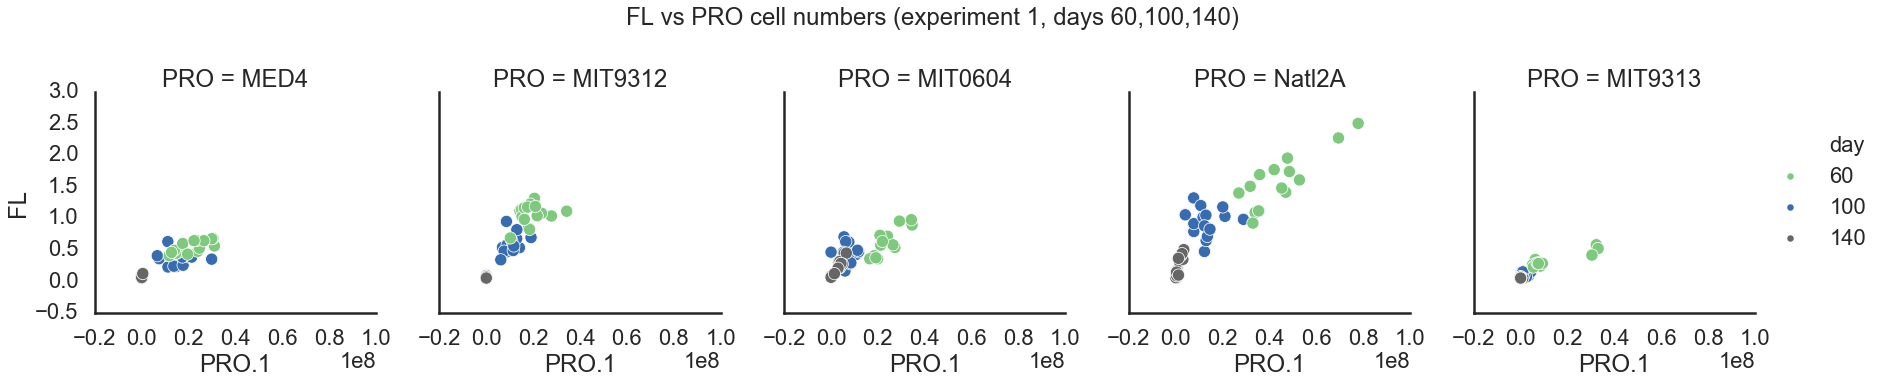

In [66]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
            palette='Accent'
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

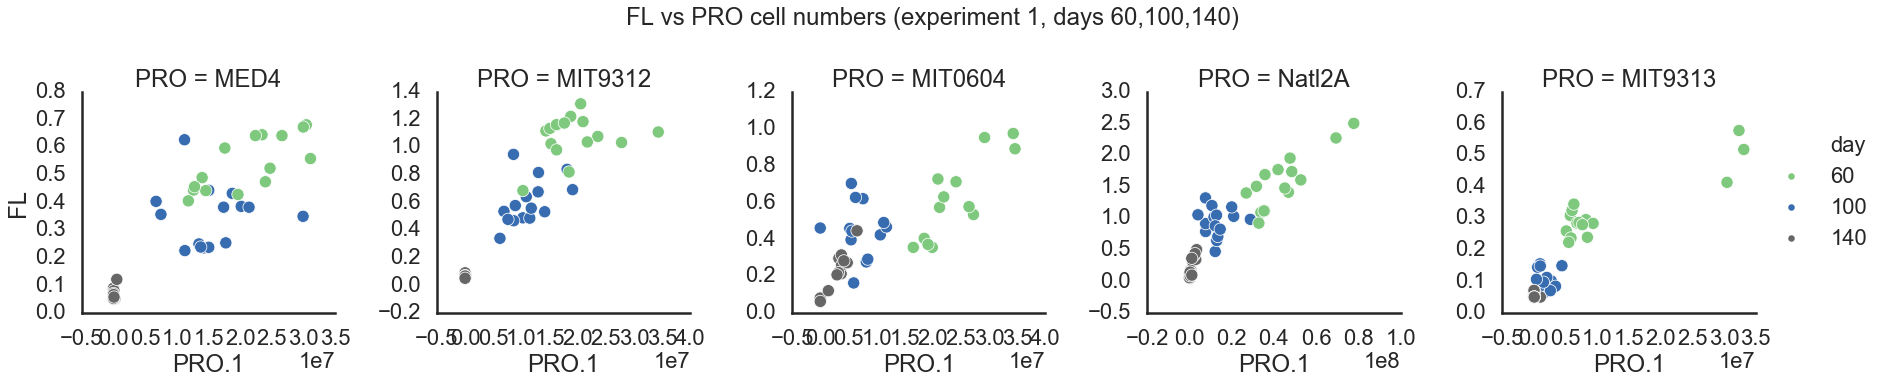

In [67]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           s=150,
            palette='Accent',
            facet_kws=dict(sharex=False, sharey=False),
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
    
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

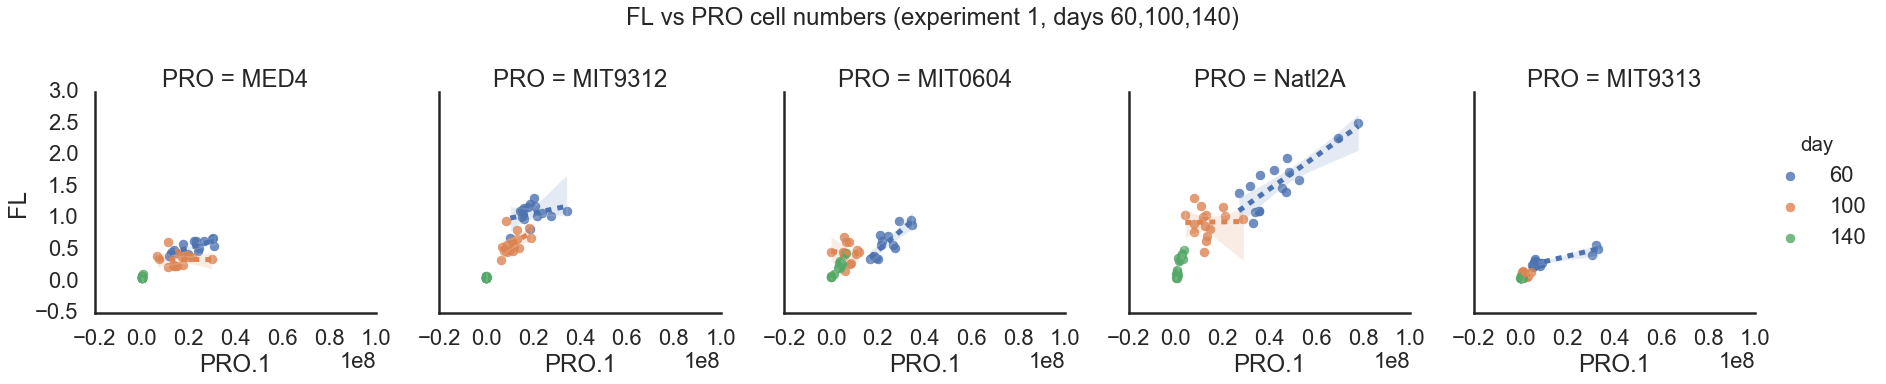

In [68]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', col='PRO', hue='day', legend='full',
           col_order=porder, #hue_order=porder, palette=ppallete,
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

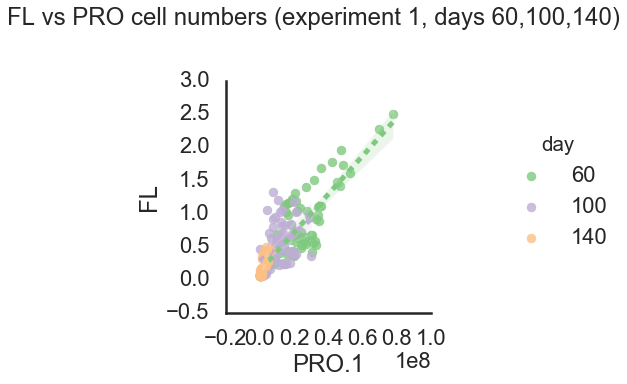

In [69]:
sns.lmplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', legend='full',
           hue='day',
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           scatter=True,
           scatter_kws=dict(s=80),
           line_kws=dict(linewidth=5, linestyle='dashed'),
           truncate=True,
           palette='Accent'
           
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

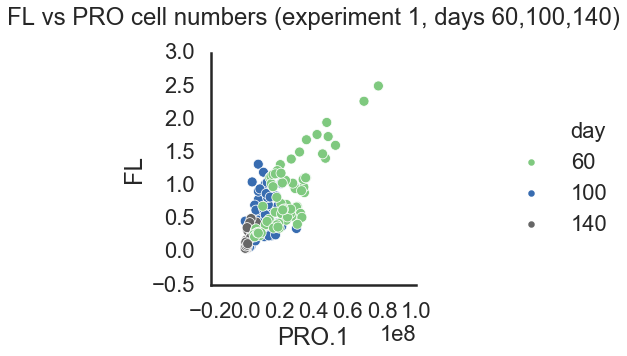

In [70]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', 
            legend='full',
           hue='day',
            s=100,
            palette='Accent'
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )

plt.title('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'ALT cells vs PRO cell numbers (experiment 1, days 60,100,140)')

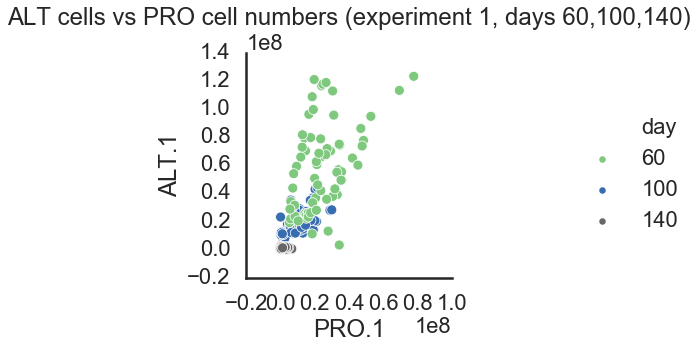

In [71]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='ALT.1', #col='PRO', hue='PRO', 
            legend='full',
           hue='day',
            s=100,
            palette='Accent'
           #col_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )

plt.title('ALT cells vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

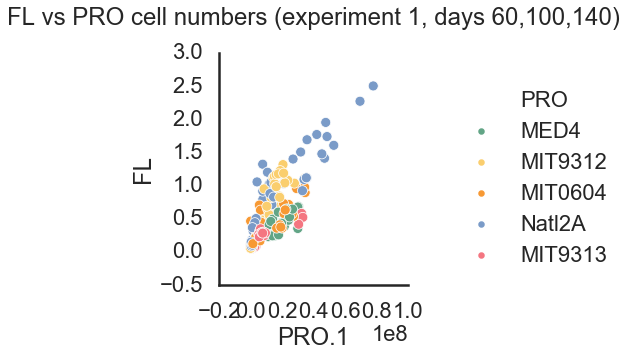

In [72]:
sns.relplot(data=df.loc[df.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', 
            legend='full',
           hue='PRO',
            s=100,
            #palette=ppallete
           hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
          )
plt.title('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

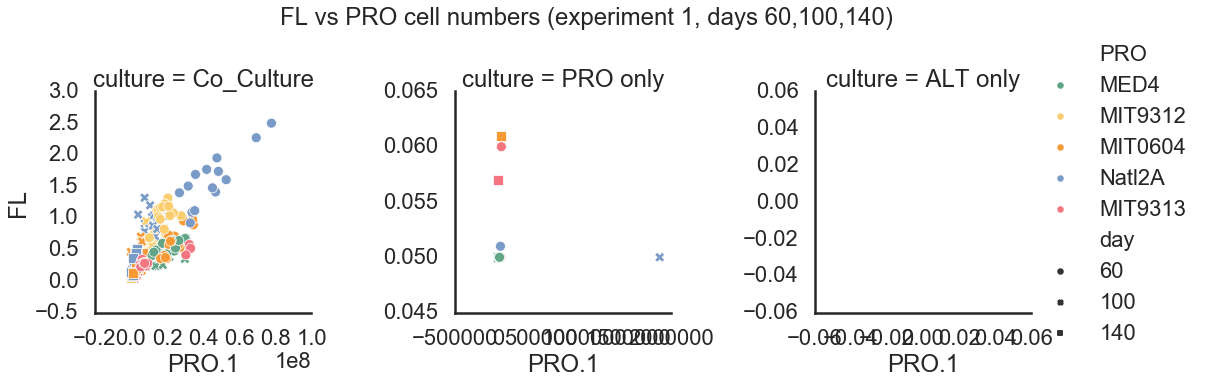

In [73]:
sns.relplot(data=dfall.loc[dfall.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', 
            legend='full',
           hue='PRO',
            s=100,
            col='culture',
            #palette=ppallete
            style='day',
           hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
            facet_kws=dict(sharex=False, sharey=False)
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

Text(0.5,1.1,'FL vs PRO cell numbers (experiment 1, days 60,100,140)')

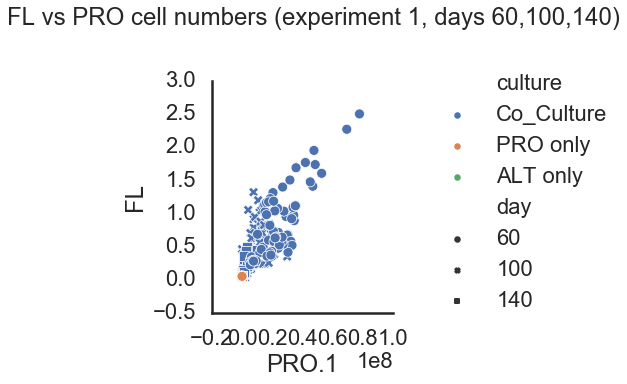

In [74]:
sns.relplot(data=dfall.loc[dfall.experiment=='exp1'], 
           x='PRO.1', y='FL', #col='PRO', hue='PRO', 
            legend='full',
           #hue='PRO',
            s=100,
            hue='culture',
            style='day',
            #palette=ppallete
           #hue_order=porder, palette=ppallete,
           #aspect=1.4, #markers=True,
           #x_ci='sd',
           #scatter=True,
           #scatter_kws=dict(s=80),
           #line_kws=dict(linewidth=5, linestyle='dashed'),
           #truncate=True
            facet_kws=dict(sharex=False, sharey=False)
          )
plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.suptitle('FL vs PRO cell numbers (experiment 1, days 60,100,140)', y=1.1)
#plt.ylabel('Number of ORFs')

In [75]:
import statsmodels.api as sm

Text(0.5,1,'pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

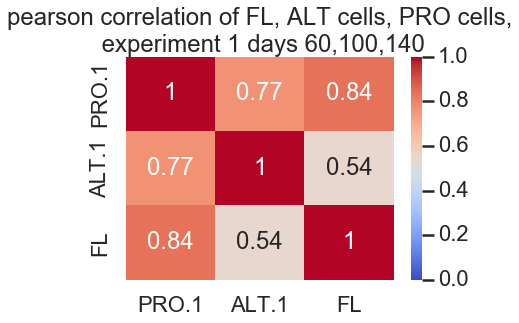

In [76]:
sns.heatmap(df.loc[df.experiment=='exp1', ['PRO.1', 'ALT.1', 'FL']].corr(), 
            cmap='coolwarm', annot=True, vmin=0)
plt.title('pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

Text(0.5,1.1,'pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140')

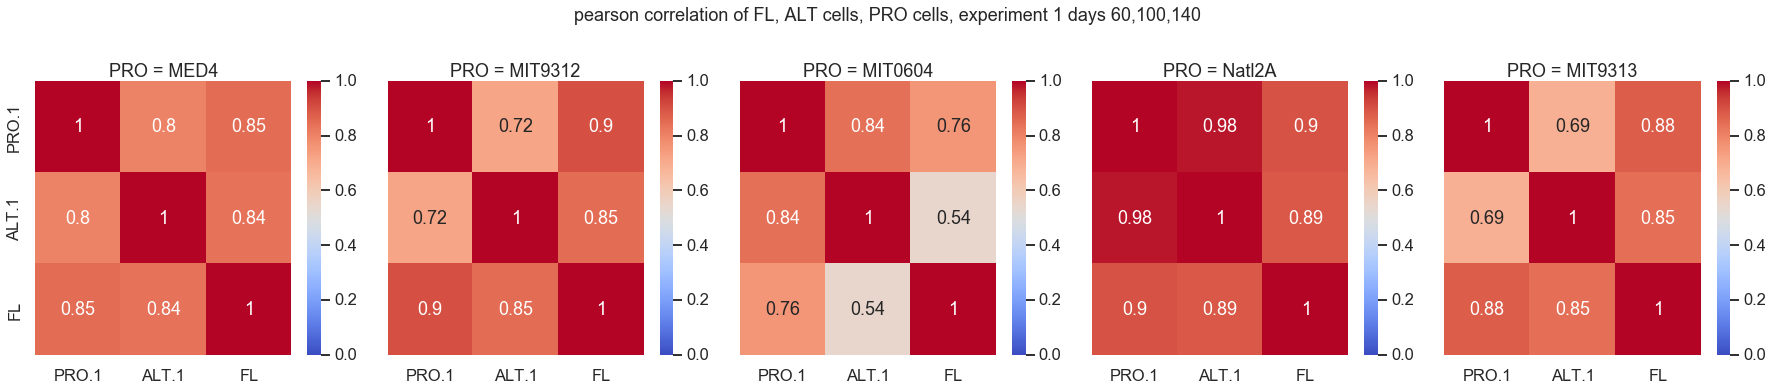

In [77]:
sns.set_context('talk')
g = sns.FacetGrid(df.loc[df.experiment=='exp1', ['PRO','ALT','PRO.1', 'ALT.1', 'FL']], 
                  col='PRO', col_order=porder, height=5)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=0, cmap='coolwarm', annot=True, vmin=0))
plt.suptitle('pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140', y=1.1)

Text(0.5,1.1,'pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140')

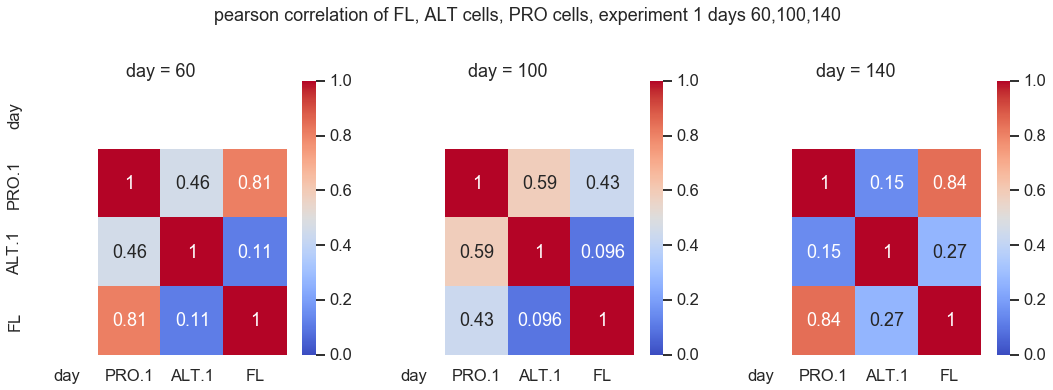

In [78]:
sns.set_context('talk')
g = sns.FacetGrid(df.loc[df.experiment=='exp1', ['PRO','ALT','day','PRO.1', 'ALT.1', 'FL']], 
                  col='day',  height=5)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=0, cmap='coolwarm', annot=True, vmin=0))
plt.suptitle('pearson correlation of FL, ALT cells, PRO cells, experiment 1 days 60,100,140', y=1.1)

Text(0.5,0.98,'pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

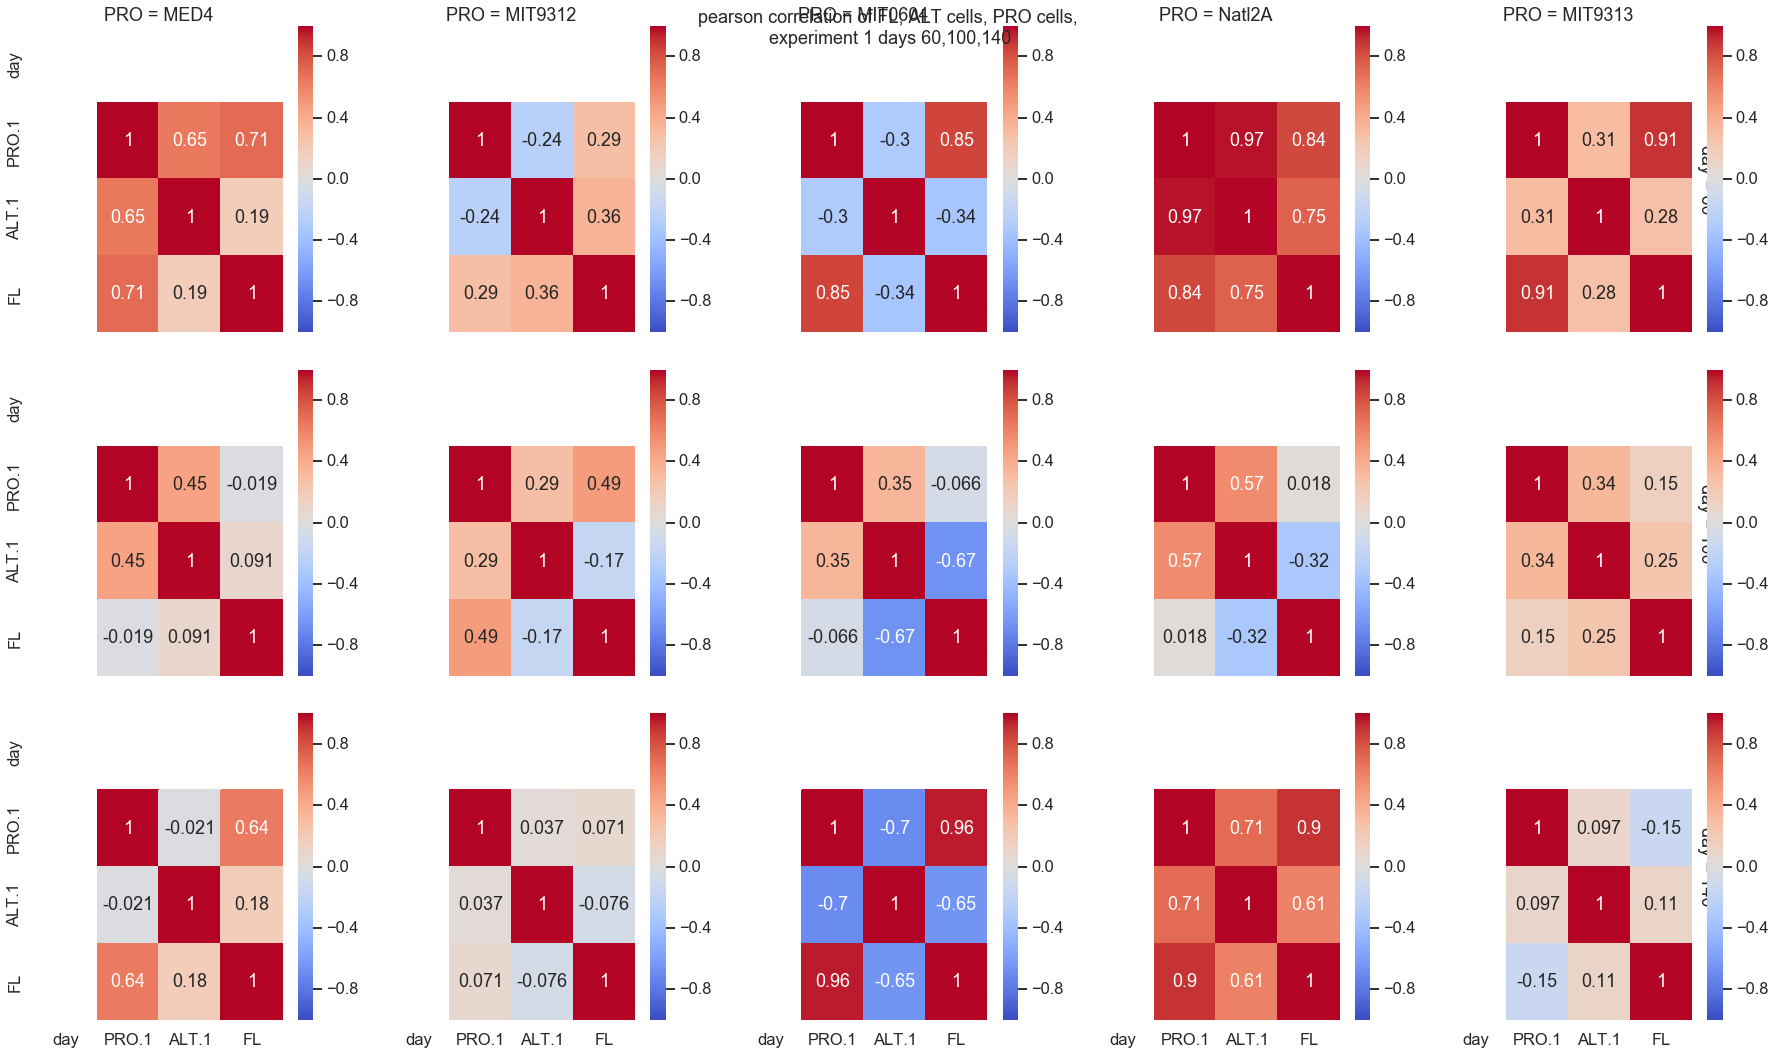

In [79]:
sns.set_context('talk')
g = sns.FacetGrid(df.loc[df.experiment=='exp1', ['PRO','ALT','day','PRO.1', 'ALT.1', 'FL']], row='day',
                  col='PRO', col_order=porder, height=5,
                  
                 margin_titles=True)
g.map_dataframe(lambda data, color: sns.heatmap(data.corr(), linewidths=0, cmap='coolwarm', annot=True, vmin=-1))
plt.suptitle('pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

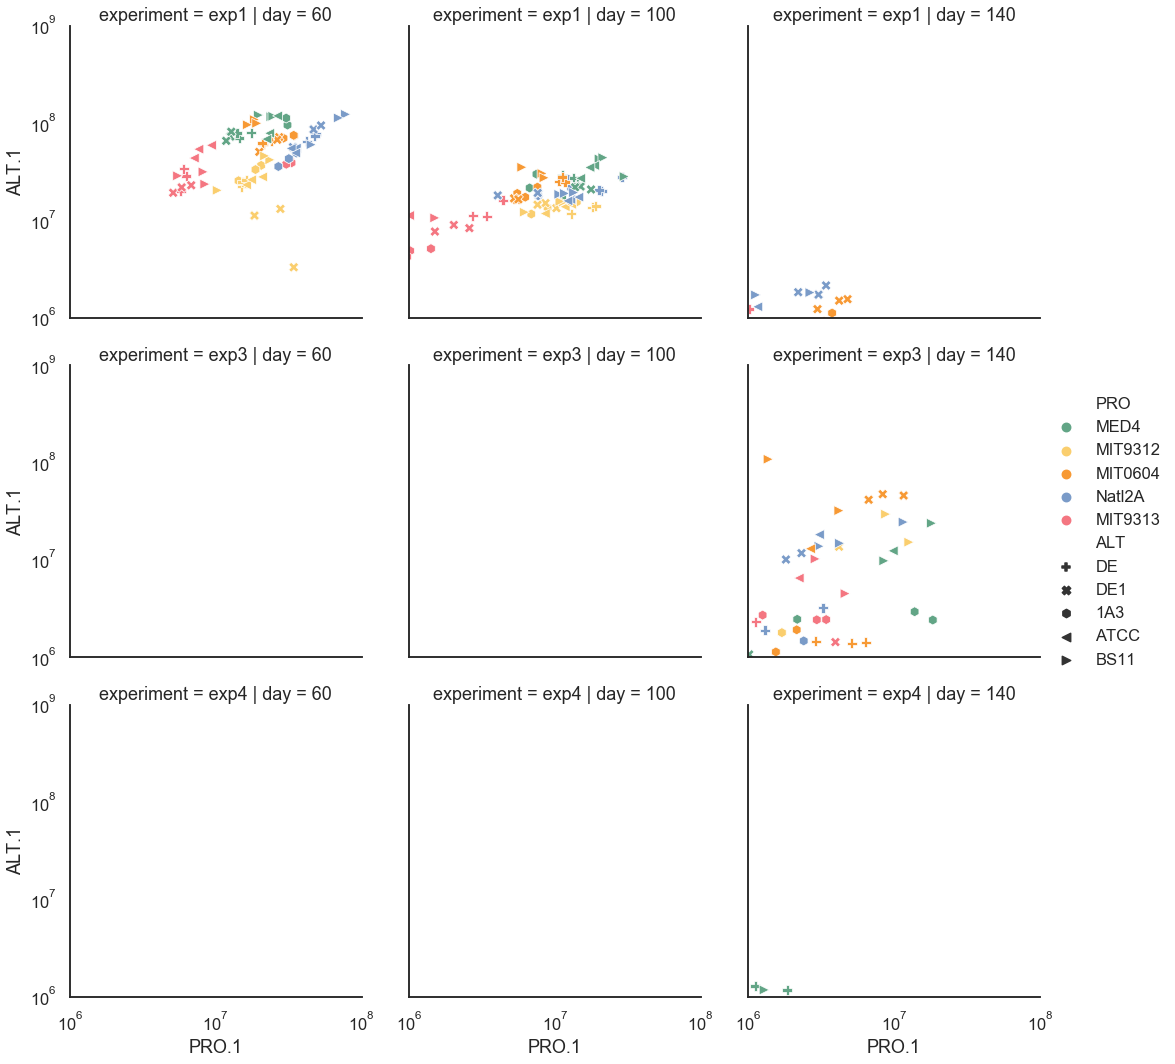

In [80]:
g= sns.relplot(data=df, x='PRO.1', y='ALT.1', col='day', row='experiment', hue='PRO', style='ALT', s=100,
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
           )
g.set(yscale='log')
g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

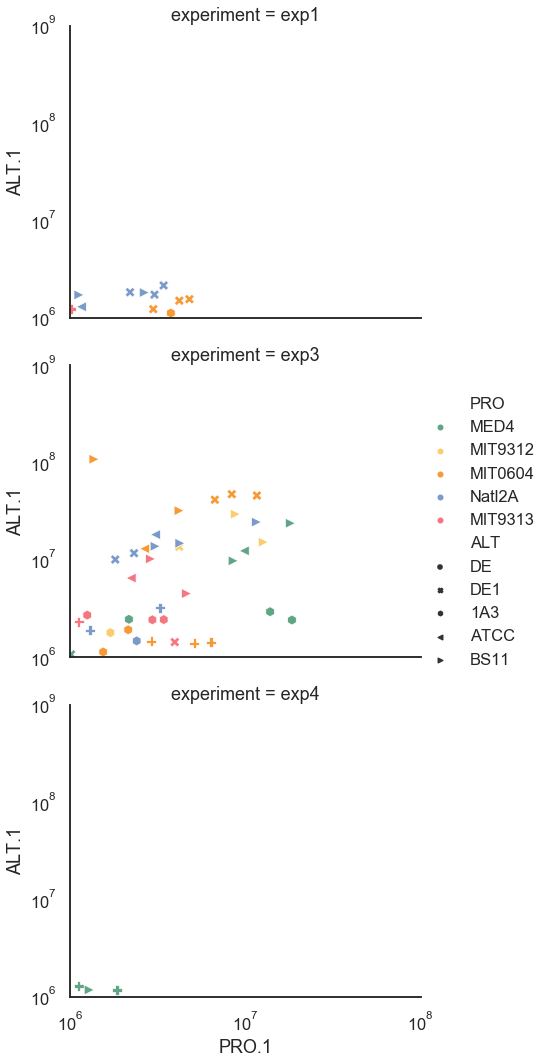

In [81]:
g =sns.relplot(data=df.loc[df['day'] == 140], 
            x='PRO.1', y='ALT.1', #col='day', 
            row='experiment', hue='PRO', style='ALT', s=100,
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers, aspect=1.3
               
           )
g.set(yscale='log')
g.set(xscale='log')

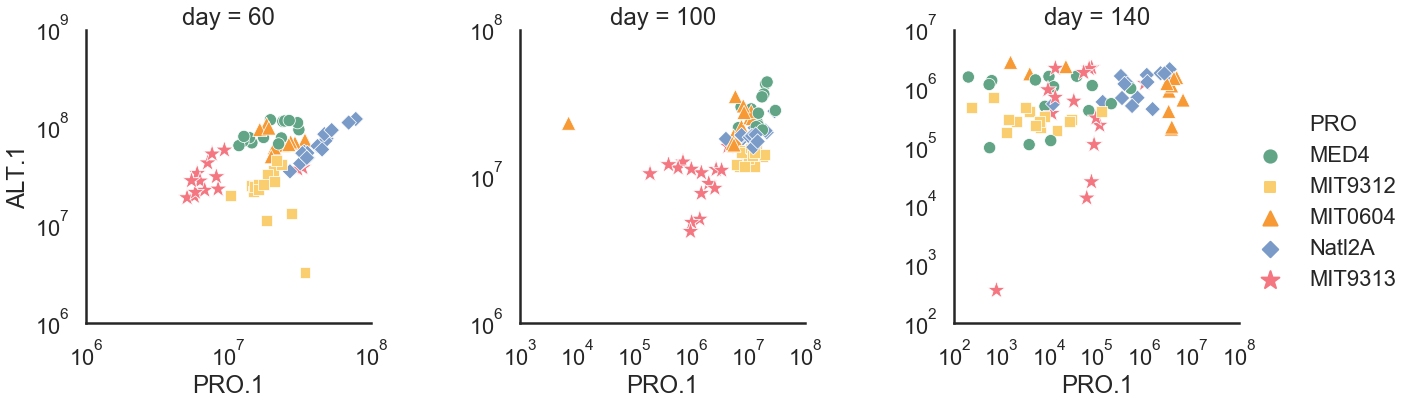

In [82]:
sns.set_context('poster')
g =sns.relplot(data=df.loc[df['experiment'] == 'exp1'], 
            x='PRO.1', y='ALT.1', #col='day', 
            col='day', hue='PRO', #style='ALT', 
               s=130,
            hue_order=porder, palette=ppallete, #style_order=aorder, markers=amarkers, 
               #aspect=1.3,
               height=6,
               style='PRO', style_order=porder, markers=pmarkers, 
               size='PRO', size_order=porder, sizes=psizes,
               facet_kws=dict(sharex=False, sharey=False)
               
           )
g.set(yscale='log')
g.set(xscale='log')

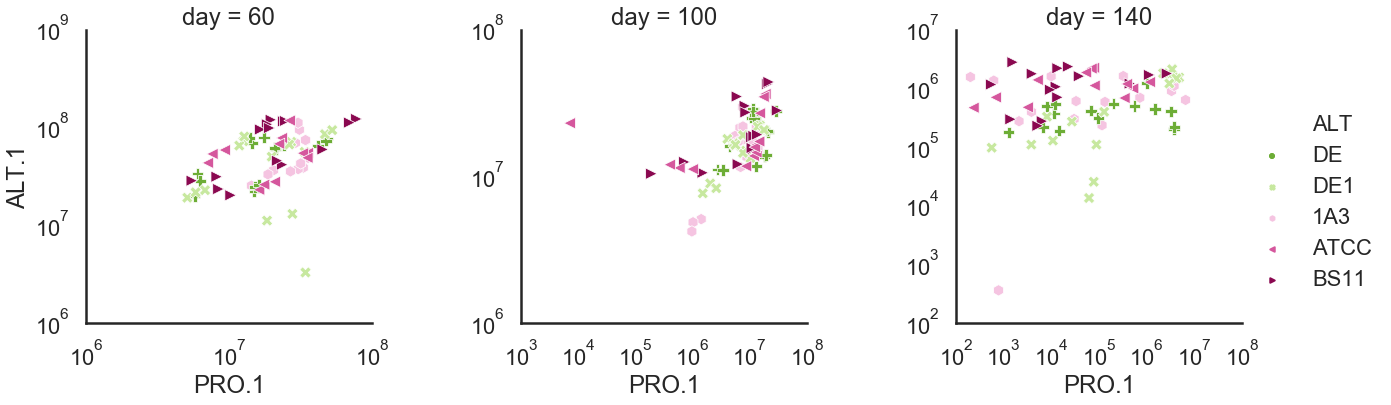

In [83]:
g =sns.relplot(data=df.loc[df['experiment'] == 'exp1'], 
            x='PRO.1', y='ALT.1', #col='day', 
            col='day', hue='ALT', #style='ALT', 
               s=130,
            hue_order=aorder, palette=apallete, #style_order=aorder, markers=amarkers, 
               #aspect=1.3,
               height=6,
               style='ALT', style_order=aorder, markers=amarkers, 
               
               facet_kws=dict(sharex=False, sharey=False)
               
           )
g.set(yscale='log')
g.set(xscale='log')

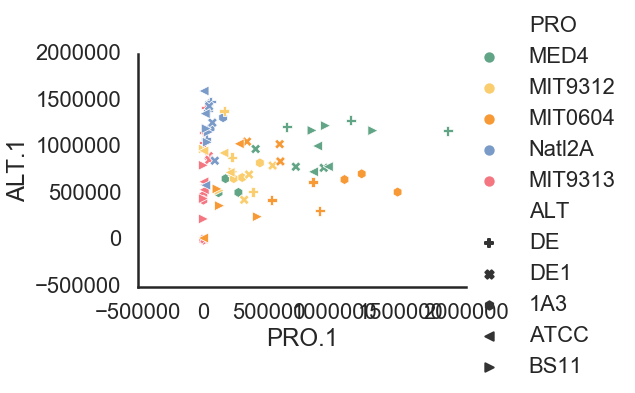

In [84]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp4')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
#g.set(yscale='log')
#g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

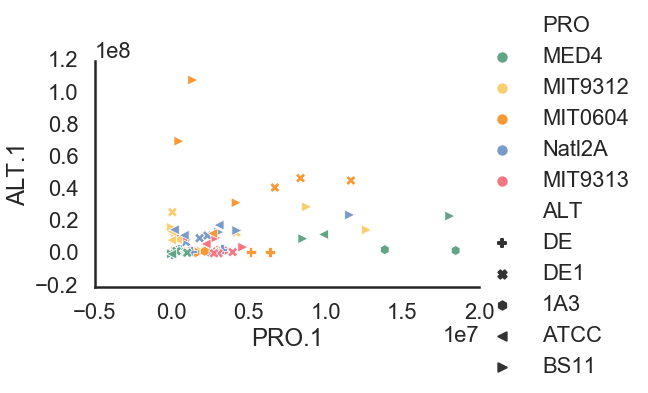

In [85]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp3')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
#g.set(yscale='log')
#g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

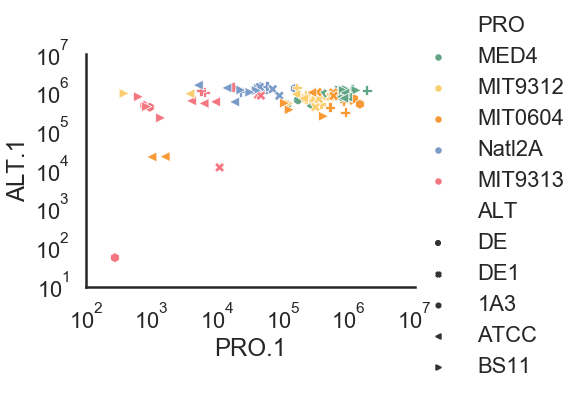

In [86]:
g =sns.relplot(data=df.loc[(df['experiment'] == 'exp4')],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
g.set(yscale='log')
g.set(xscale='log')

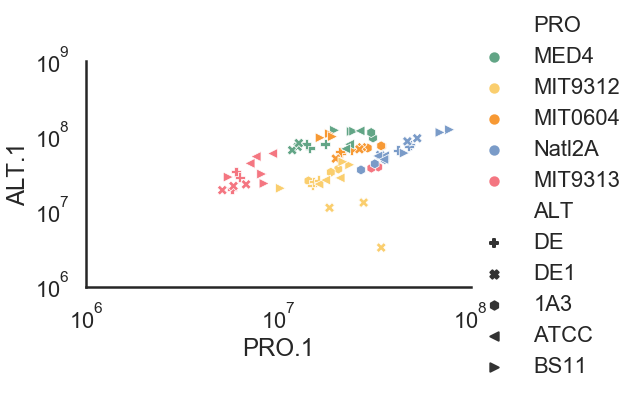

In [87]:
g =sns.relplot(data=df.loc[(df['day'] == 60)],
            x='PRO.1', y='ALT.1', #col='day', row='experiment', 
            hue_order=porder, palette=ppallete, style_order=aorder, markers=amarkers,
            hue='PRO', style='ALT', s=100, aspect=1.5)
g.set(yscale='log')
g.set(xscale='log')
for lh in g._legend.legendHandles: 
    lh.set_sizes([70])

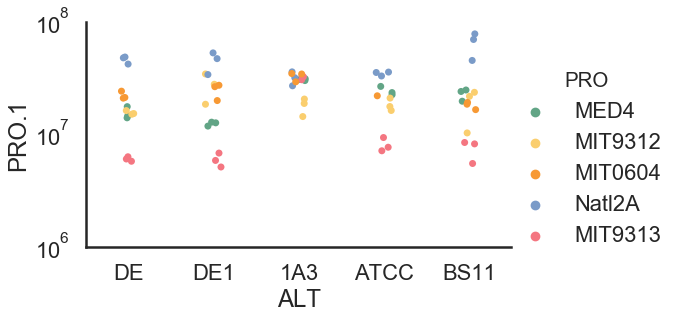

In [88]:
g = sns.catplot(data=df.loc[df.day==60], 
          x='ALT', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               order=aorder,
                palette=ppallete,
                s=7,

               )
g.set(yscale='log')


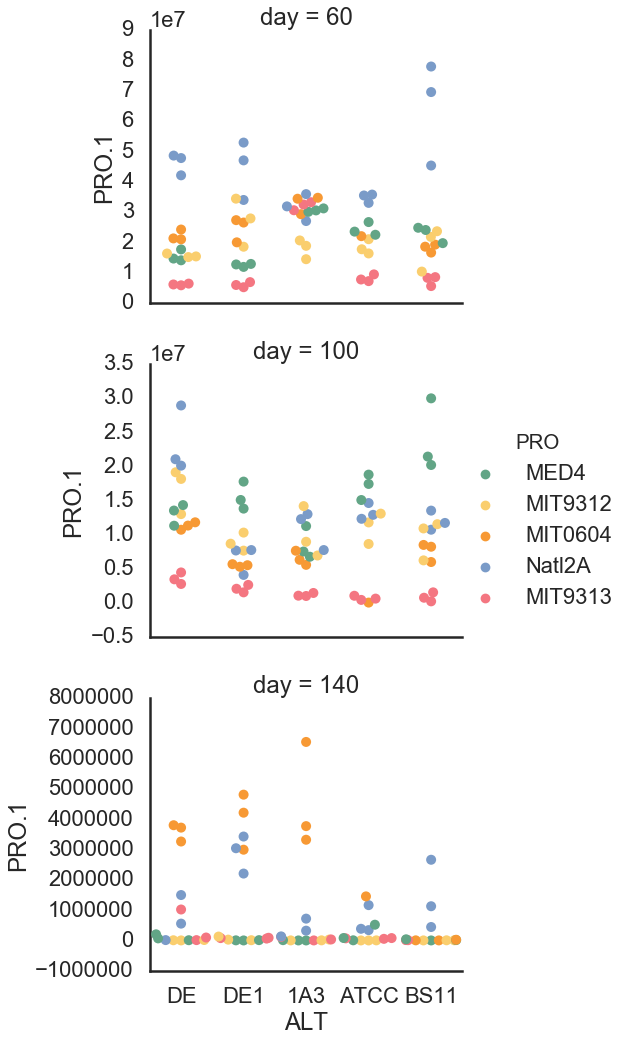

In [89]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='ALT', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               order=aorder,
                palette=ppallete,
                s=10,
                #kind='swarm',
                row='day',
                sharey=False,
               #facet_kws=dict(sharey=False)
                kind='swarm',
               )
#g.set(yscale='log')
#plt.ylim((1,1.5e8))
#for lh in g._legend.legendHandles: 
#    lh.set_sizes([70])

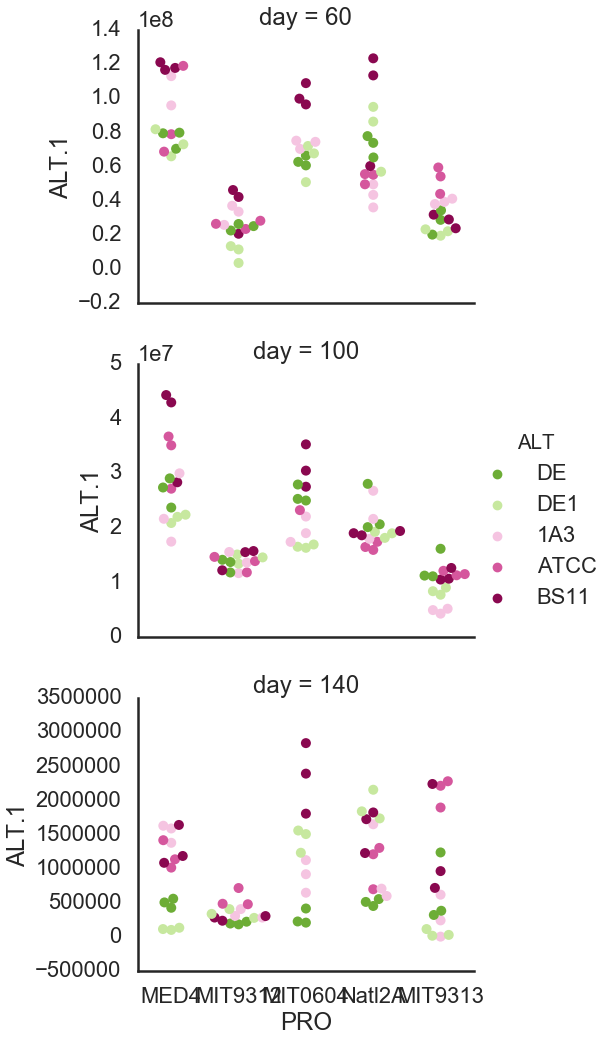

In [90]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='PRO', y='ALT.1', 
                hue='ALT', 
                aspect=1.5,
                hue_order=aorder,
               order=porder,
                palette=apallete,
                s=10,
                row='day',
                sharey=False,
                kind='swarm',
                
               )
#plt.ylim((1,1.5e8))
#g.set(yscale='log')
#for lh in g._legend.legendHandles: 
#    lh.set_sizes([70])

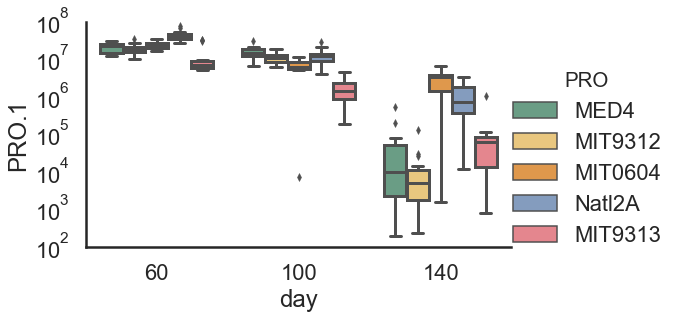

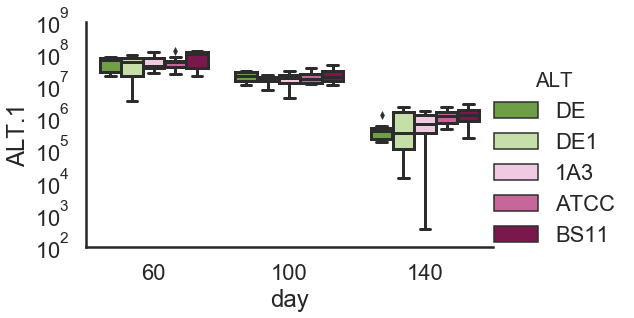

In [91]:
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='day', y='PRO.1', 
                hue='PRO', 
                aspect=1.5,
                hue_order=porder,
               #order=porder,
                palette=ppallete,
                sharey=False,
                kind='box',
                
               )
plt.yscale('log')
g = sns.catplot(data=df.loc[df.experiment=='exp1'], 
          x='day', y='ALT.1', 
                hue='ALT', 
                aspect=1.5,
                hue_order=aorder,
               #order=porder,
                palette=apallete,
                sharey=False,
                kind='box',
                
               )
plt.yscale('log')


In [92]:
df.loc[df['ALT.1'].isna()]

PRO   ALT sample         PRO.1  ALT.1 experiment  day     FL
179  MIT0604  ATCC    25C  1.452120e+06    NaN       exp1  140  0.120
212     MED4   1A3     1C  2.996083e+07    NaN       exp1   60  0.672
284  MIT0604  ATCC    25C  2.194349e+07    NaN       exp1   60  0.629
387  MIT0604  ATCC    25A  7.095344e+04    NaN       exp3  140    NaN
388  MIT0604  ATCC    25B  4.589800e+04    NaN       exp3  140    NaN

# model based on FCM data

In [93]:
def _load_fcm_fl_csv(data_dpath, fname):
    df = pd.read_csv(os.path.join(data_dpath, fname), index_col=0, header=None).T
    #df = df.reset_index()
    # remove rows and columns that are all nan
    df = df.dropna(how='all')
    df = df.loc[:, df.columns.notnull()] 
    df['Sample'] = os.path.splitext(fname)[0]
    df.VALUE = pd.to_numeric(df.VALUE)
    df.day = pd.to_numeric(df.day)
    df['MODE'] = df.EXP.str.split('_', expand=True)[1]
    return df

In [94]:

data_dpath = r'fcm_and_fl'
csv_fnames = [ n for n in os.listdir(data_dpath) if n.endswith('.csv')]
temp_dfs = [_load_fcm_fl_csv(data_dpath, fname) for fname in csv_fnames]
prevfcm_df = pd.concat(temp_dfs)
prevfcm_df.loc[prevfcm_df['MODE']== 'PRO99','MODE'] = 'pro99'
prevfcm_df.loc[prevfcm_df.Sample == '9313 LD_FL1', 'PRO'] = 'MIT9313'
prevfcm_df = prevfcm_df.fillna({'ALT': 'N/A'}, )


In [95]:
prevfcm_df.head()

0   day         VALUE          EXP METHOD      PRO  ALT          Sample  MODE
1   6.0  4.005340e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN
2   8.0  8.172664e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN
3  11.0  1.038500e+08  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN
4  13.0  8.916974e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN
5  15.0  5.294342e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN

In [96]:
def get_fl_day(df, row):
    x = row['day']
    e = row['EXP']
    
    possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >= x) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >x-1) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        flday =  None
        flval = None
    else: 
        flday =  possible_days[0]
        flval = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day == flday), 'VALUE' ].unique()[0]
    return pd.Series({'fl_day': flday, 'FL': flval})
        
    

d = prevfcm_df.apply(lambda x: get_fl_day(prevfcm_df,x), axis=1)
prevfcm_df = pd.concat([prevfcm_df, d], axis=1)
compdf = prevfcm_df.loc[prevfcm_df.METHOD == 'FCM']
compdf.rename(columns={'VALUE': 'FCM'}, inplace=True)

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [97]:
compdf.dropna(axis='rows', inplace=True)

C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
compdf.head()

day           FCM          EXP METHOD      PRO  ALT          Sample  MODE  \
1   6.0  4.005340e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN   
2   8.0  8.172664e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN   
3  11.0  1.038500e+08  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN   
4  13.0  8.916974e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN   
5  15.0  5.294342e+07  9312_lowN_1    FCM  MIT9312  N/A  9312 lowN_FCM1  lowN   

   fl_day     FL  
1    6.96  3.178  
2    7.88  3.863  
3   10.88  4.302  
4   13.86  2.699  
5   14.87  1.404

In [99]:
compdf.MODE.unique()

array(['lowN', 'lowP', 'pro99', 'LD', '1A3'], dtype=object)

In [111]:
#compdf1 = compdf.loc[compdf.MODE.isin(['lowN', '1A3'])]
compdf1 = compdf
X = compdf1['FL']
y = compdf1['FCM']
res = sm.OLS(y, sm.add_constant(X)).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    FCM   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     643.3
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           1.40e-80
Time:                        10:37:50   Log-Likelihood:                -6491.6
No. Observations:                 344   AIC:                         1.299e+04
Df Residuals:                     342   BIC:                         1.299e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.778e+06   3.47e+06      0.801      0.4

C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [112]:
df_fl.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day     FL
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  0.356
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  0.403
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  0.626
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  0.101
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  0.050

C:\Users\wosnat\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2446: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


(10456286.777831556, 0.3370288605183177)

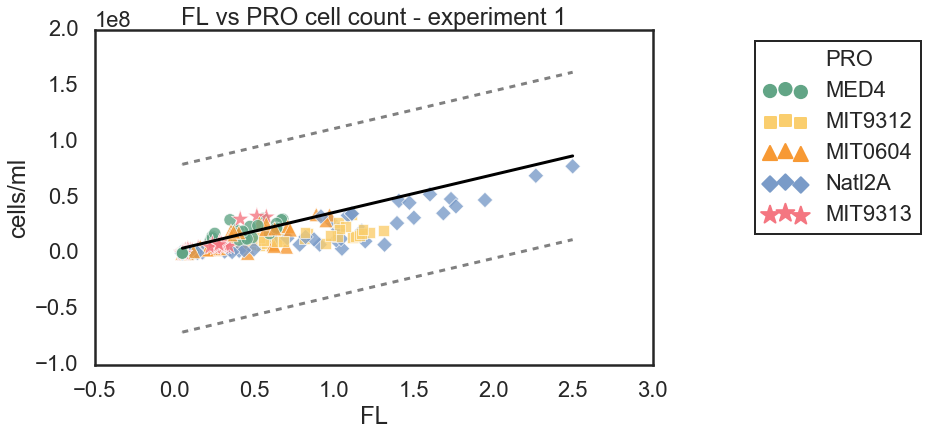

In [113]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_style('white')
sns.set_context('poster')
dt = res.get_prediction(sm.add_constant(df_fl['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

ax=sns.scatterplot(data=df_fl, x=df_fl.FL, y=df_fl['PRO.1'], hue=df_fl.PRO, hue_order=porder, palette=ppallete, s=80,
                   style='PRO', style_order=porder, markers=pmarkers, size='PRO', size_order=porder, sizes=psizes,
                   alpha=0.8
                  )
sns.lineplot(x=df_fl['FL'], y=y_pred, ax=ax, c='black')
sns.lineplot(x=df_fl['FL'], y=yprd_ci_lower, c='grey', ax=ax)
sns.lineplot(x=df_fl['FL'], y=yprd_ci_upper,  c='grey', ax=ax)

ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")

plt.ylabel('cells/ml')
plt.title('FL vs PRO cell count - experiment 1')
plt.legend(bbox_to_anchor=(1.5,1))
rmse(df_fl['PRO.1'], y_pred), r2_score(df_fl['PRO.1'], y_pred)


C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(37957899.726926155, 0.6528902819788596)

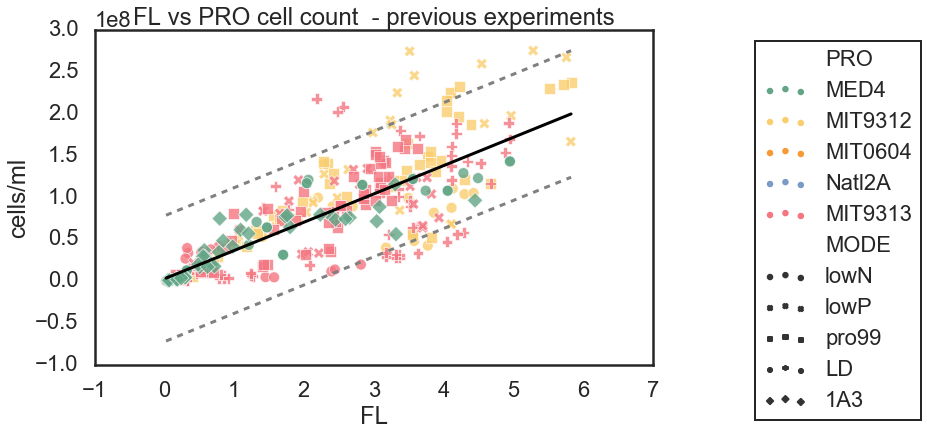

In [114]:
dt = res.get_prediction(sm.add_constant(compdf1['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

ax = sns.scatterplot(x=compdf1.FL, y=compdf1.FCM, hue=compdf1.PRO, hue_order=porder, palette=ppallete, 
                     style=compdf1.MODE, s=120,
                #style='PRO', style_order=porder, markers=pmarkers, size='PRO', size_order=porder, sizes=psizes,
                   alpha=0.8
               )
sns.lineplot(x=compdf1['FL'], y=y_pred, color='black', ax=ax)
sns.lineplot(x=compdf1['FL'], y=yprd_ci_lower, color='grey', ax=ax)
sns.lineplot(x=compdf1['FL'], y=yprd_ci_upper, color='grey', ax=ax)
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
plt.legend(bbox_to_anchor=(1.5,1))

plt.ylabel('cells/ml')
plt.title('FL vs PRO cell count  - previous experiments')


rmse(compdf1['FCM'], y_pred), r2_score(compdf1['FCM'], y_pred)

In [115]:
d = prevfcm_df.loc[prevfcm_df.METHOD == 'FL']
def get_max_day(x):
    maxidx = x['VALUE'].idxmax()
    maxday = x.loc[maxidx]['day']
    return maxday
max_days = d.groupby('EXP').apply(get_max_day)
decline_compdf = compdf.loc[compdf['day'] >= max_days[compdf['EXP']].values]

In [116]:
decline_compdf1 = decline_compdf.loc[decline_compdf.MODE.isin(['lowN', '1A3'])]
X = decline_compdf1['FL']
y = decline_compdf1['FCM']
res = sm.OLS(y, sm.add_constant(X)).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    FCM   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     329.3
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           9.09e-28
Time:                        10:37:57   Log-Likelihood:                -1265.6
No. Observations:                  70   AIC:                             2535.
Df Residuals:                      68   BIC:                             2540.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.365e+06   2.82e+06      3.316      0.0

C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [106]:
df_fl.head()

PRO  ALT sample         PRO.1         ALT.1 experiment  day     FL
0     MED4  1A3     1A  7.485642e+06  2.992351e+07       exp1  100  0.356
1     MED4  1A3     1B  6.720907e+06  2.159764e+07       exp1  100  0.403
2     MED4  1A3     1C  1.121335e+07  1.742056e+07       exp1  100  0.626
3  MIT9313  1A3     2A  1.415617e+06  5.134250e+06       exp1  100  0.101
4  MIT9313  1A3     2B  1.018640e+06  4.885134e+06       exp1  100  0.050

(14186330.580367602, -0.22033706764327232)

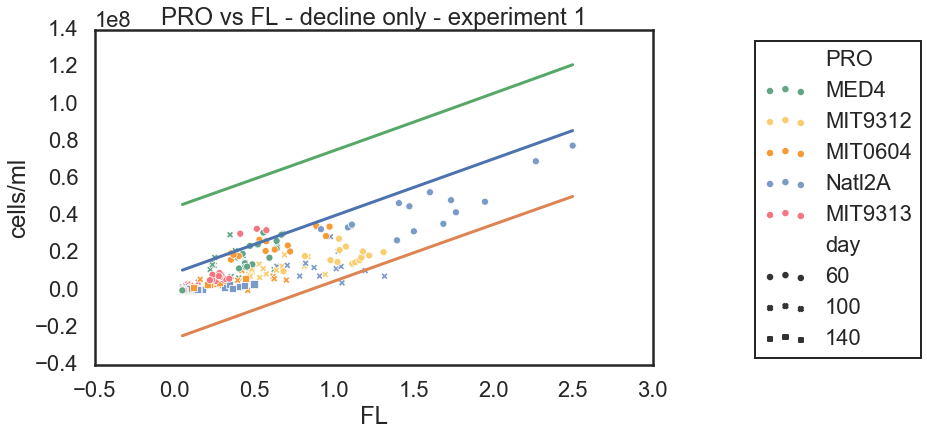

In [107]:
dt = res.get_prediction(sm.add_constant(df_fl['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=df_fl.FL, y=df_fl['PRO.1'], hue=df_fl.PRO, hue_order=porder, palette=ppallete, s=50,
               #style=df_fl.ALT,
                style=df_fl['day'])
sns.lineplot(x=df_fl['FL'], y=y_pred)
sns.lineplot(x=df_fl['FL'], y=yprd_ci_lower)
sns.lineplot(x=df_fl['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - experiment 1')
plt.legend(bbox_to_anchor=(1.5,1))

rmse(df_fl['PRO.1'], y_pred), r2_score(df_fl['PRO.1'], y_pred)



C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(17214225.448846515, 0.8288459843577876)

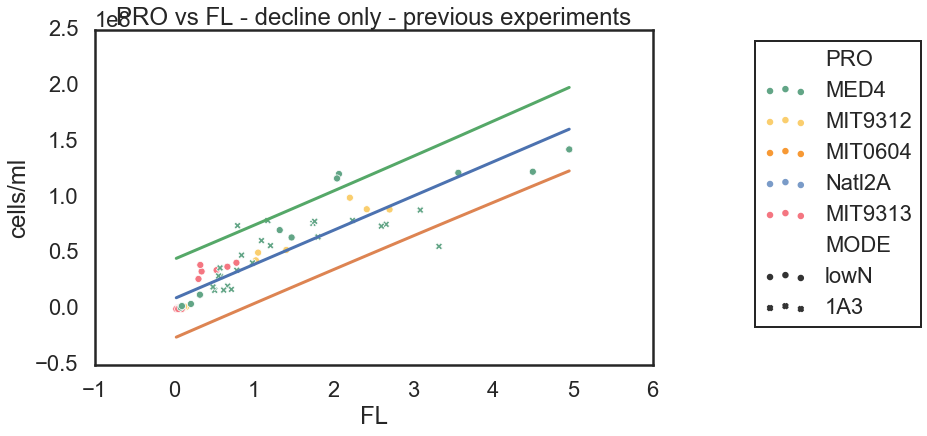

In [109]:
dt = res.get_prediction(sm.add_constant(decline_compdf1['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=decline_compdf1.FL, y=decline_compdf1.FCM, hue=decline_compdf1.PRO, 
                hue_order=porder, palette=ppallete, style=decline_compdf1.MODE, s=50)
sns.lineplot(x=decline_compdf1['FL'], y=y_pred)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_lower)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - previous experiments')
plt.legend(bbox_to_anchor=(1.5,1))


rmse(decline_compdf1['FCM'], y_pred), r2_score(decline_compdf1['FCM'], y_pred)

C:\Users\wosnat\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(17214225.448846515, 0.8288459843577876)

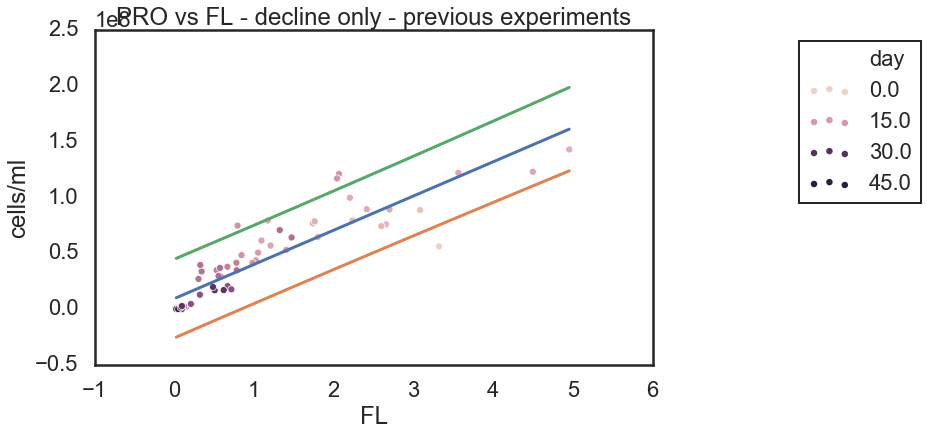

In [110]:
dt = res.get_prediction(sm.add_constant(decline_compdf1['FL'])).summary_frame(alpha = 0.05)
y_pred = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

sns.scatterplot(x=decline_compdf1.FL, y=decline_compdf1.FCM, hue=decline_compdf1.day, 
                #hue_order=porder, palette=ppallete, style=decline_compdf1.MODE, 
                s=50)
sns.lineplot(x=decline_compdf1['FL'], y=y_pred)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_lower)
sns.lineplot(x=decline_compdf1['FL'], y=yprd_ci_upper)
plt.ylabel('cells/ml')
plt.title('PRO vs FL - decline only - previous experiments')
plt.legend(bbox_to_anchor=(1.5,1))


rmse(decline_compdf1['FCM'], y_pred), r2_score(decline_compdf1['FCM'], y_pred)